\newpage

## DSS Prototype Overview ##

### System Context ###

Figure 1 depicts the context for the DSS. The DSS operator interacts with the DSS Prototype for decision assitance. The DSS relies on a aircraft database to gather real-time flight data to review in decision support algorithms.

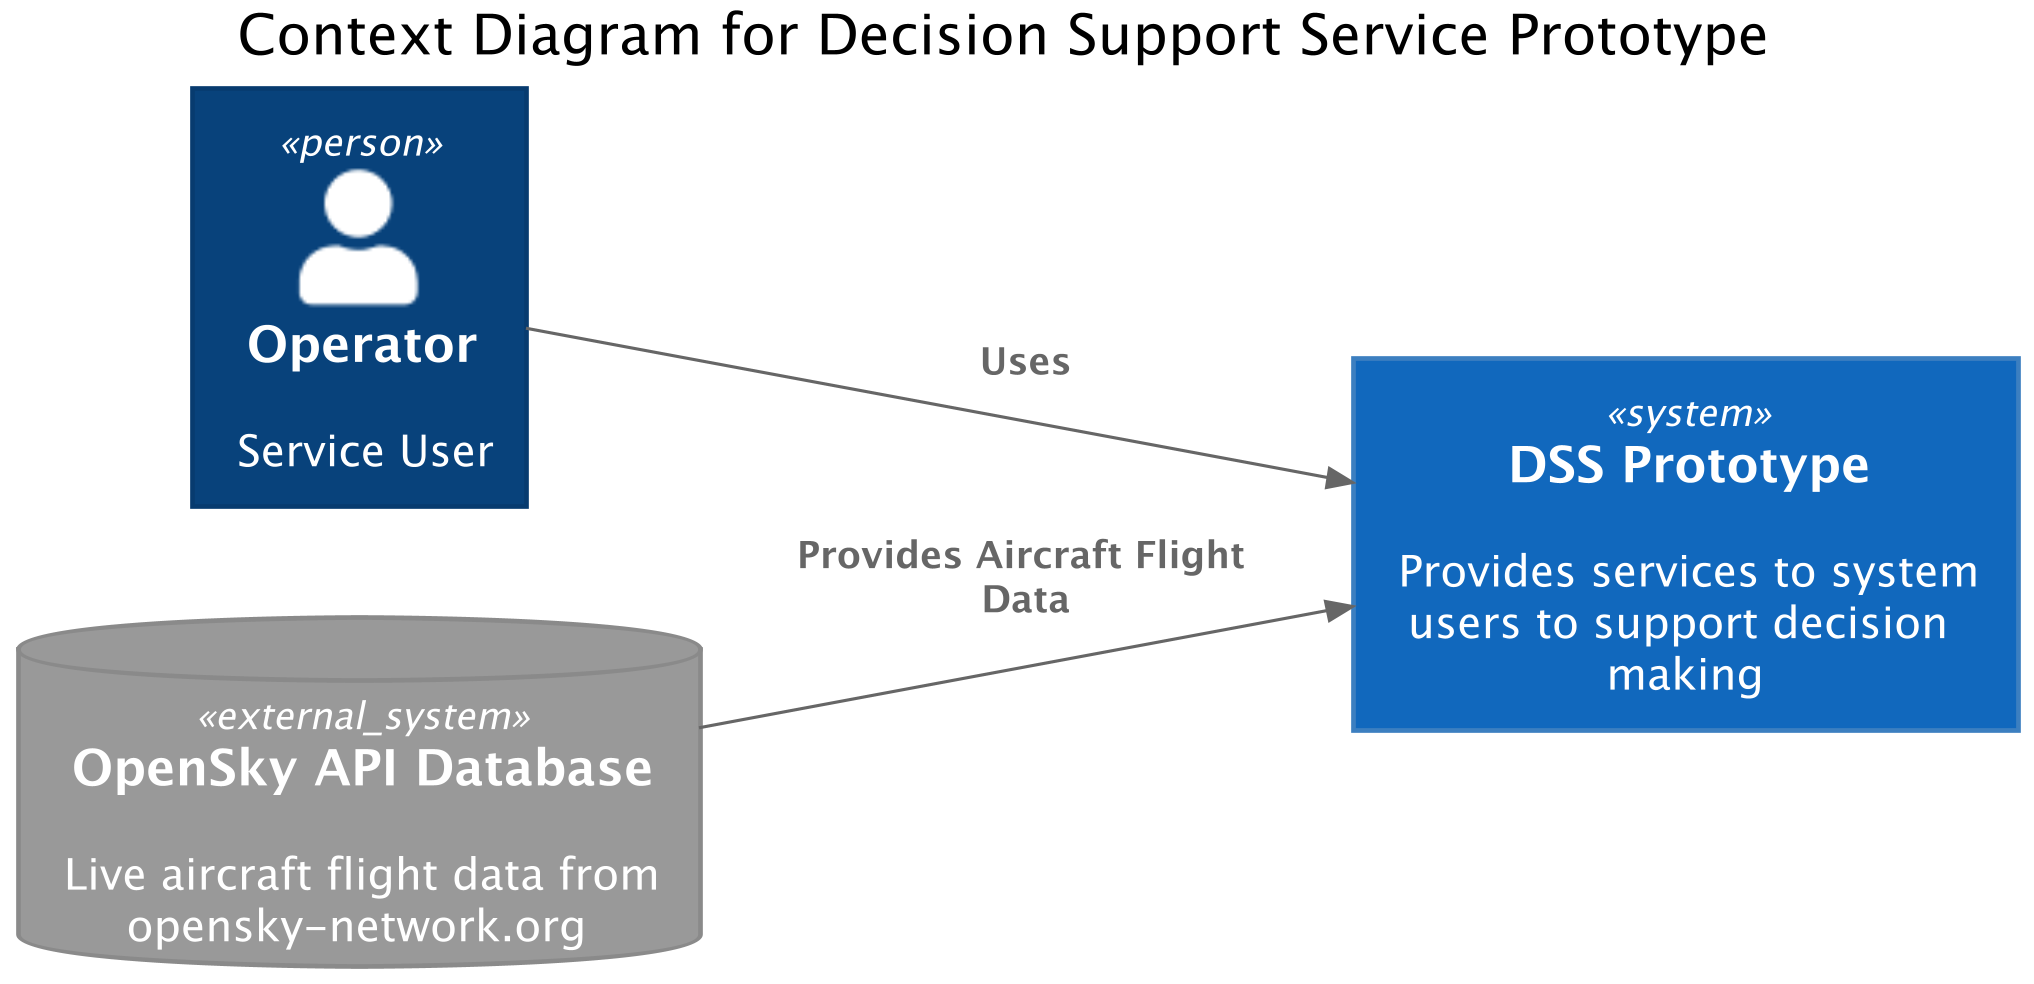

### Container Architecture ###

Nine containers are instantiated as part of the DSS architecuture (see Figure 2). Six provide the DSS implementation while the additional 3 support collection and calculation of metrics. Each application container was designed around the 12-Factor Application "Single Responsibility Principle"; e.g. each app has one purpose to enable rapid insertion of new capabilities with low cohesion to other functionality. At this time, all responses are canned without underlying calculations to focus on meeting the 500 ms hypothesis pryor to burdening the application with calculation latency.

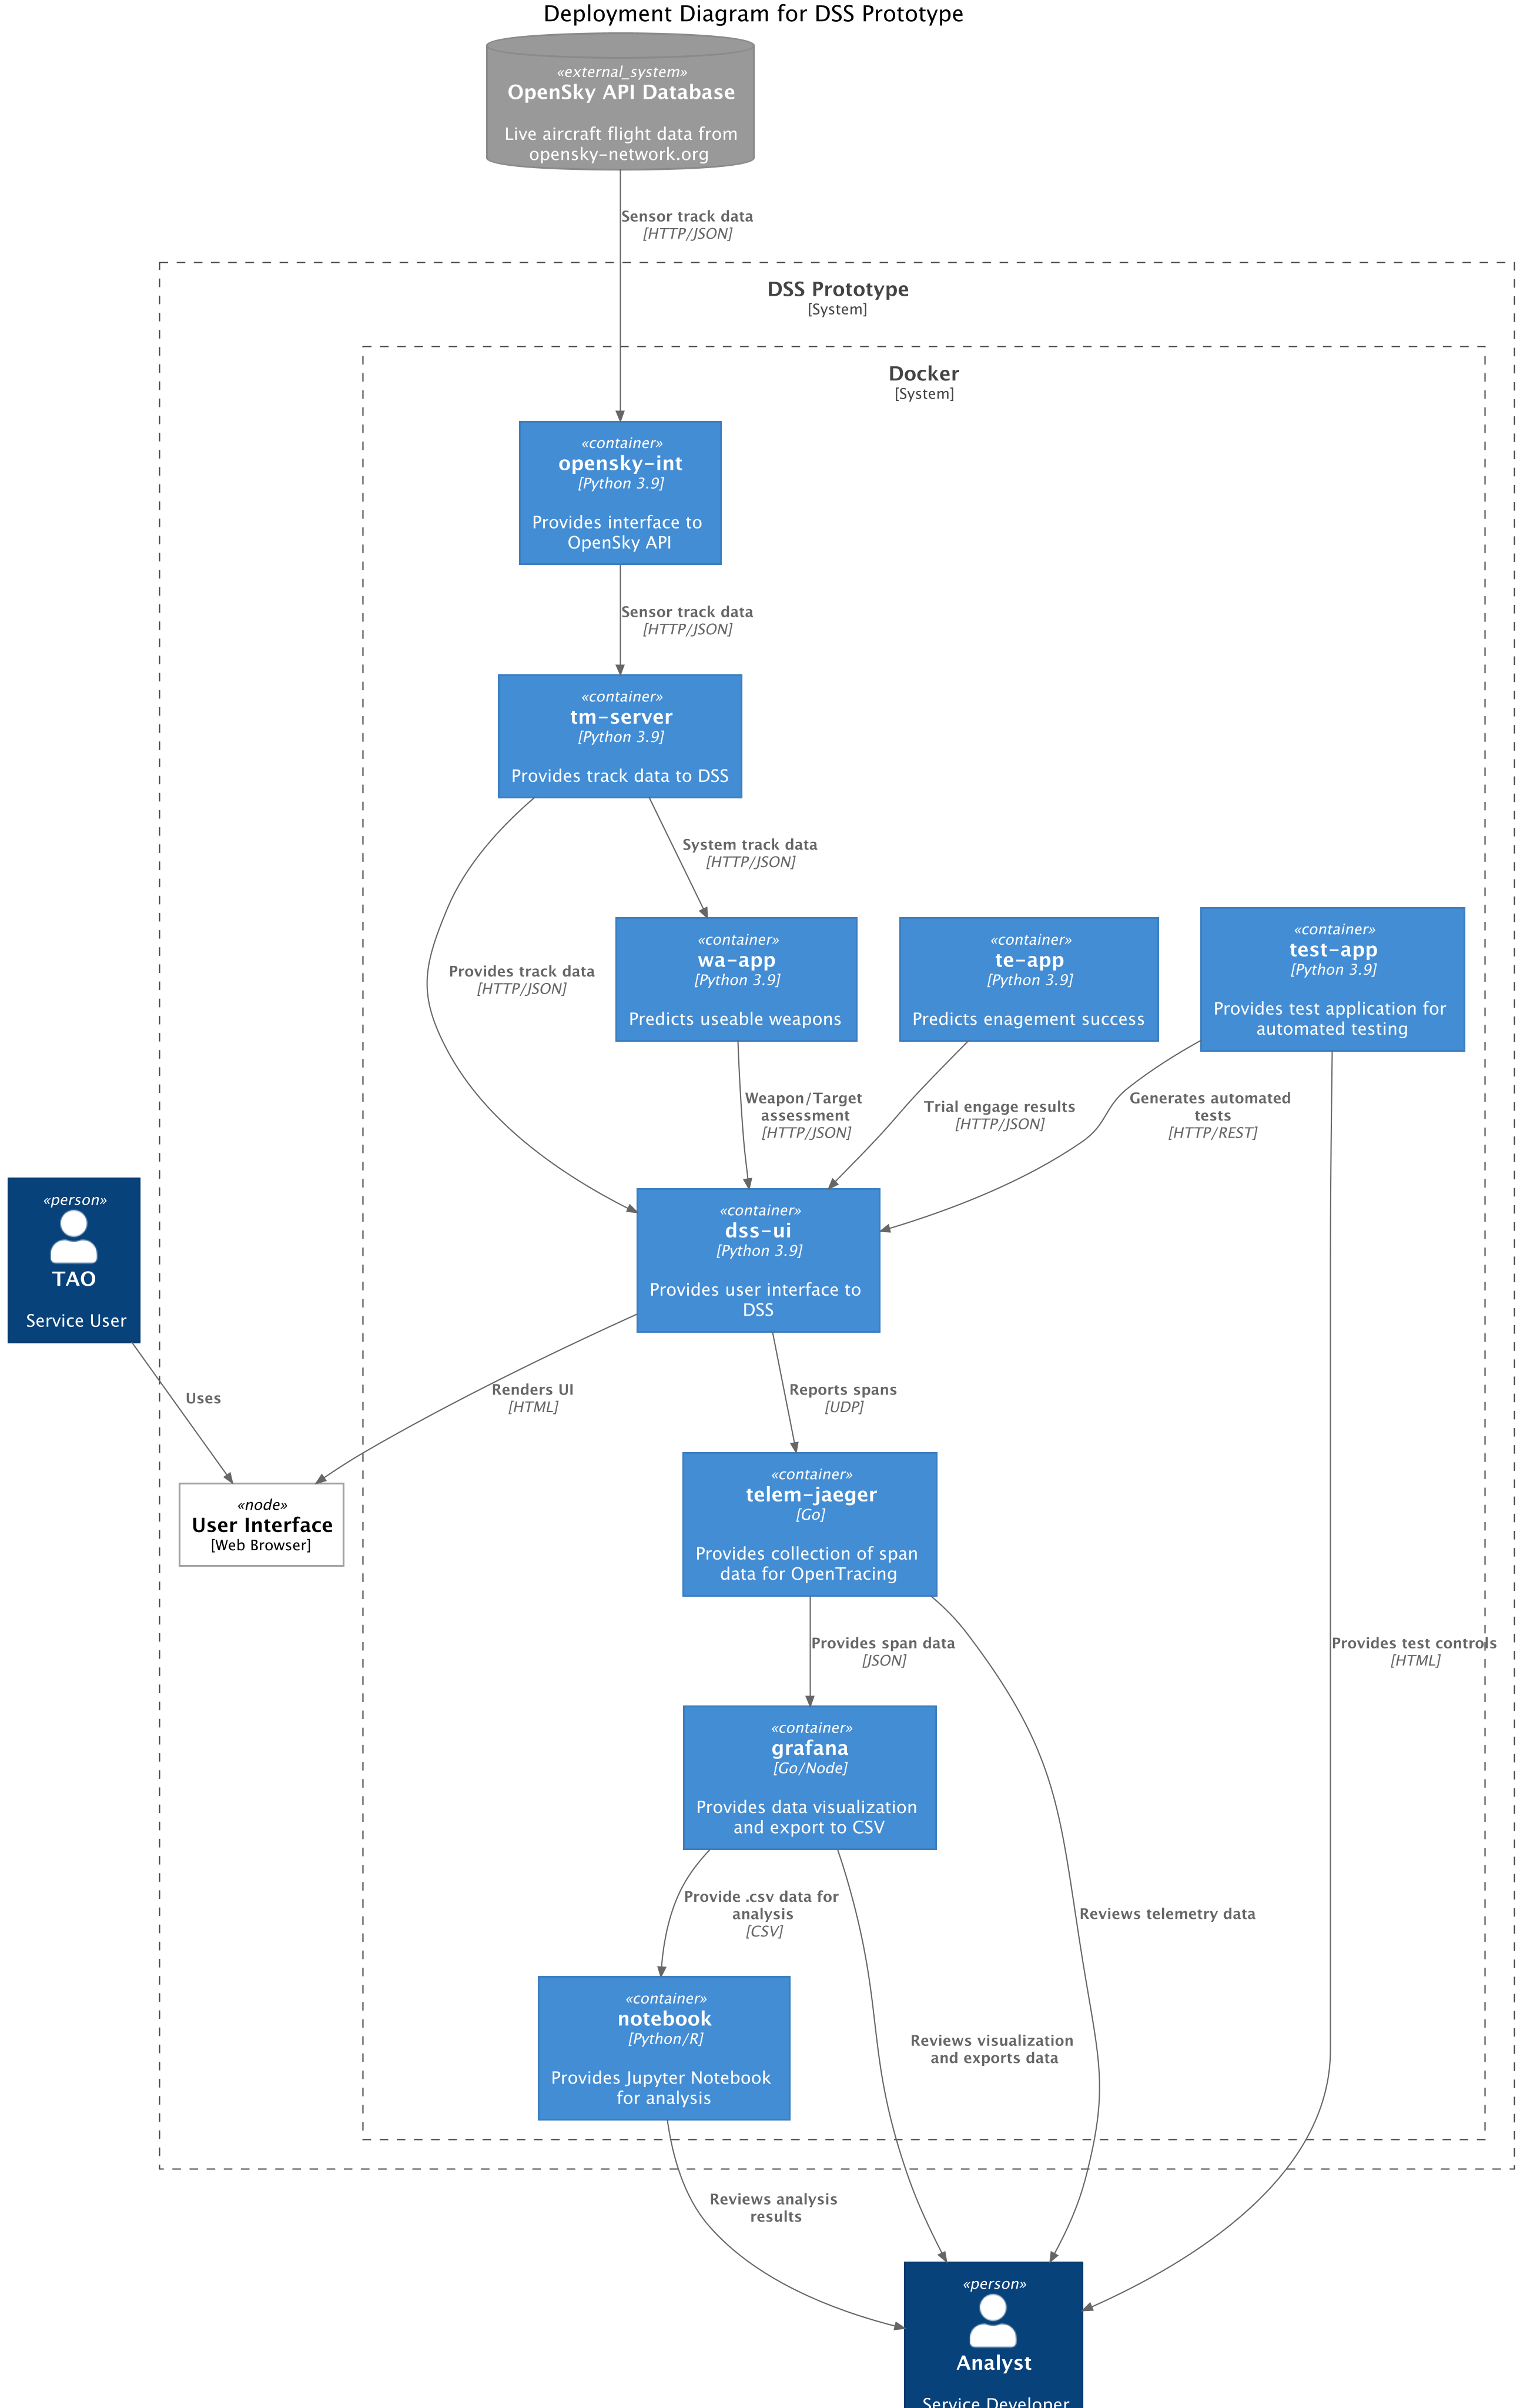

#### Applications ####

- opensky-int: Provides the OpenSky API for flight data. The app provides data about aircraft within 60 NM of Richmond (RIC) or Dulles (IAD) airports.
- tm-server: Provides sensor track data (e.g. OpenSky) and system tracks to support DSS services. System tracks represent the system-wide common understanding of track object states used for decision support.
- wa-app: The Weapon Assessment Application determines which weapons are capable to successfully engage a target. The wa-app uses the tm-server api to get track data.
- te-app: The Trail Engage Application predicts the success probability of an engagement with a specific weapon target pairing. The predicted track kinematic data at engagement time is provided; therefore, the current track kinematics from the tm-server are not queried prior to providing a response.
- test-app: Provides an ability to initiate automated tests. the test-app uses the dss-ui to call dss-ui endpoint to replicate operator interactions with the DSS Prototype.
- dss-ui: Provides a simple graphical interface to launch DSS services.

#### Tools ####

- telem-jaeger: The open source Jaeger containter collects "span" data from the DSS applications. Spans collect duration data for service calls amongst containers; e.g. latency. This the fundamental data that is being analysed here.
- grafana: The open source Grafana container connects to the telem-jaeger container to create visualization dashboards. Also, Grafana faciliates the export of data as a .csv file for analysis.
- notebook: The Jupyter Notebook container supports analysis of the data recorded by Jaeger and exported by Grafana. An embedded R software library is used for analysis.

<!-- 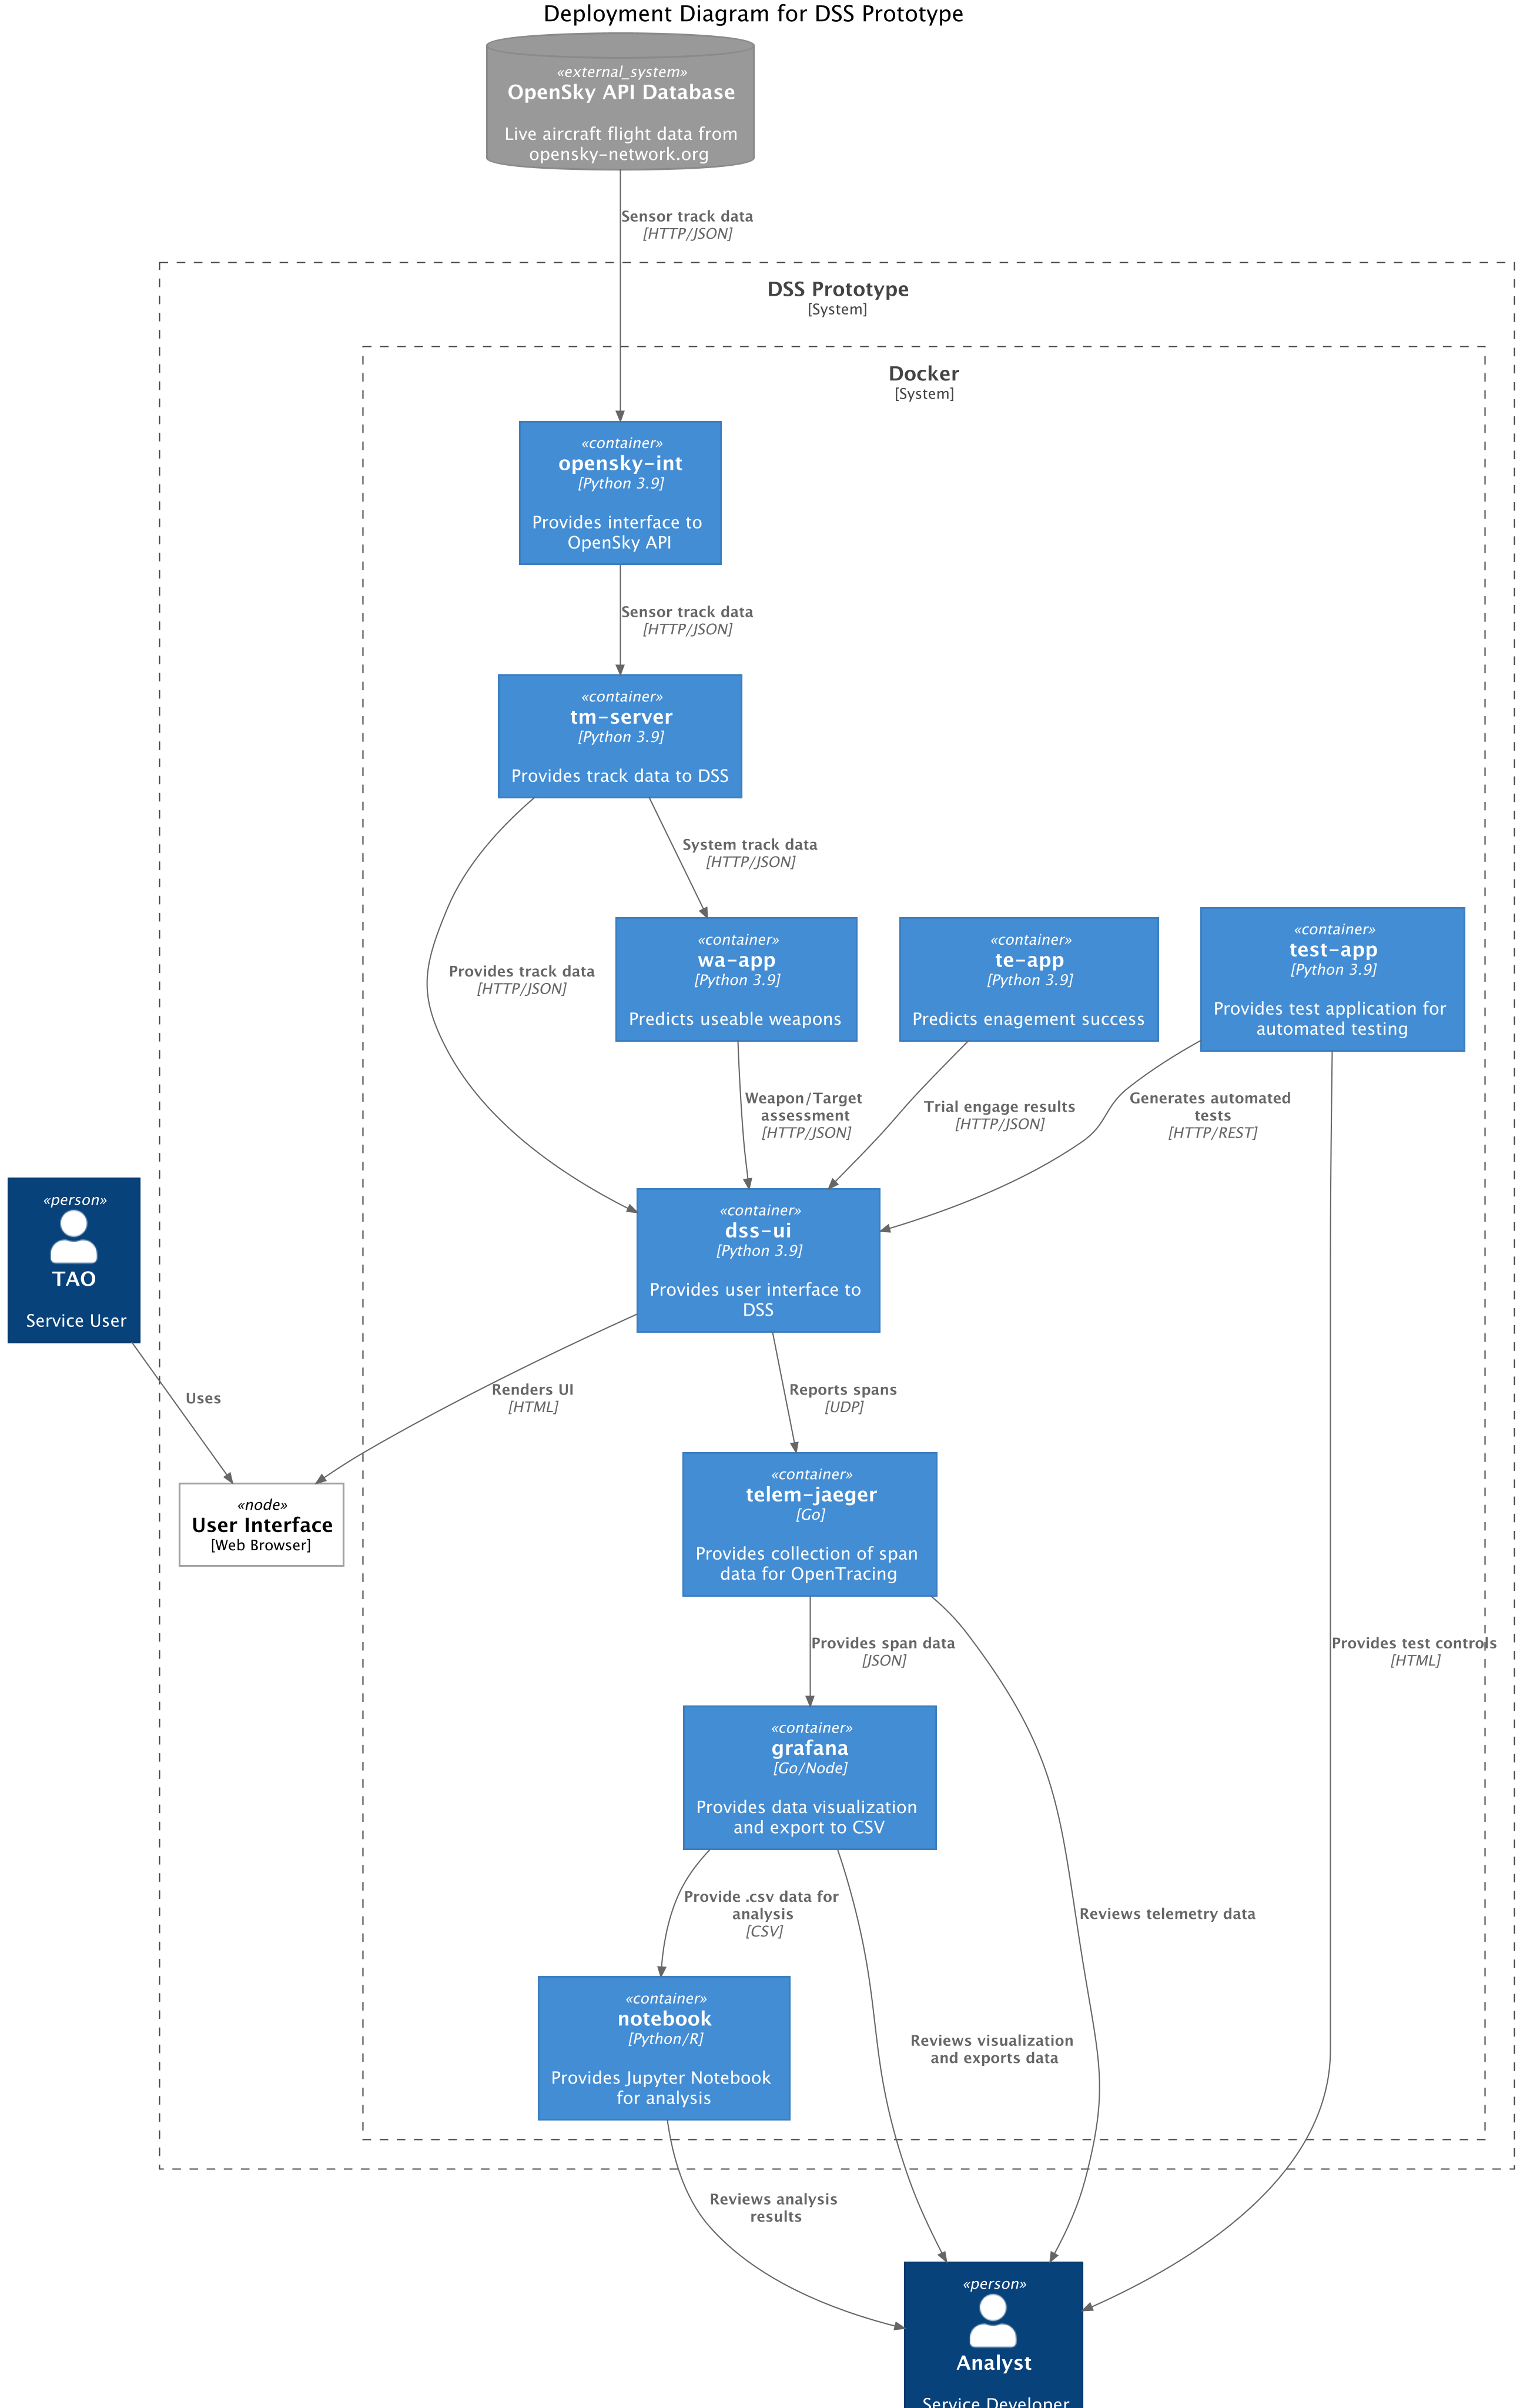 -->

### Hypothesis ###

Hypotheses are "innocent until proven guilty." We'll assume that SpaceX and others have proven that DevSecOps tech can meet hard-real-time requirements but nothing available in the body of knowledge documents this.

**Hypothesis:** Modern DevSecOps architectures can be designed to meet hard-real-time latency ($\mu$) requirements using modern computing environments and computing infrastructure.

$H_0: \mu \le 500  ms$ with jitter within latency bounds   
$H_a: \mu > 500  ms$ with jitter exceeding latency bounds  


_Murphy, Alvin C. and Moreland Jr, James D. ‘Integrating AI Microservices into Hard-Real-Time SoS to Ensure Trustworthiness of Digital Enterprise Using Mission Engineering’. 1 Jan. 2021 : 38 – 54._

In [1]:
install.packages("stringr")                # Install packages and libraries in R
library(stringr, quietly = TRUE)
# suppressPackageStartupMessages(library("stringr"))

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
install.packages("dplyr")
library(dplyr, quietly = TRUE)

install.packages("ggplot2") 
install.packages("GGally")
library(ggplot2, quietly = TRUE)                     
library(GGally, quietly = TRUE)

# Note that loading MASS will cause issues with dplyr select
library("MASS")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




In [3]:
install.packages("mclust")
library(mclust, quietly = TRUE)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Package 'mclust' version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



In [4]:
if(!require(rcompanion)){install.packages("rcompanion")}
library(rcompanion, quietly = TRUE)

Loading required package: rcompanion



In [5]:
# install the package 
if(!require(rcompanion)){install.packages("ggstatsplot")}

# Load the package
library(ggstatsplot, quietly = TRUE)



You can cite this package as:
     Patil, I. (2021). Visualizations with statistical details: The 'ggstatsplot' approach.
     Journal of Open Source Software, 6(61), 3167, doi:10.21105/joss.03167



In [6]:
options(warn=-1)

In [7]:
setwd('/home/jovyan/work/data')

## Load Data Files ##

In [8]:
macData <- read.csv('DSS_SpanData-mac-2022-05-02 18_38_26_s10-5-1.csv', header = TRUE)
linpcData <- read.csv('DSS_SpanData-linuxpc-2022-06-06 17_38_29_s10-5-1.csv', header = TRUE)
rpi4Data <- read.csv('DSS_SpanData-rpi4-2022-06-06 17_52_59_s10-5-1.csv', header = TRUE)
awsEC2Data <- read.csv('DSS_SpanData-aws_ec2-2022-06-07 17_44_08_s10-5-1.csv', header = TRUE)
cci_Data <- read.csv('DSS_SpanData-odu_cci-2022-06-28 17_47_20_s10-5-1.csv', header = TRUE)

### Review and Tag MacBook Air (2017) Data ###

In [9]:
summary(macData)

   Trace.ID          Trace.name         Start.time          Duration        
 Length:100         Length:100         Length:100         Length:100        
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  

In [10]:
head(macData[, c(1,2)])
head(macData[, c(3,4)])

,Trace.ID,Trace.name
,<chr>,<chr>
1,9ee3577fb1b427bc4fc17fecc5154d7d,dss-prototype: /TE
2,f05ddc4dc13aff5c3098011b2a402401,dss-prototype: /tracks
3,2bd901fbbfc9ee8dfa7c9629d93a1567,dss-prototype: /IAD
4,69a48381a14e79da08aaa2353f7db4b2,dss-prototype: /RIC
5,e83037dcb9438c04dc12fba373b5502f,dss-prototype: /WA
6,7e381cd880adb670bb9627ca47020938,dss-prototype: /TE


,Start.time,Duration
,<chr>,<chr>
1,2022-05-02 10:25:01.366,36.0 ms
2,2022-05-02 10:25:00.309,43.3 ms
3,2022-05-02 10:24:58.818,464 ms
4,2022-05-02 10:24:57.307,494 ms
5,2022-05-02 10:24:56.128,139 ms
6,2022-05-02 10:24:55.081,30.3 ms


#### Add Source Indicator to MacBook Data ####

In [11]:
macDataPlat <- macData

macDataPlat$platform = "2017-macbook"
macDataPlat$env = 0

### Tag Linux PC (2012) Data ###

In [12]:
linpcDataPlat <- linpcData

linpcDataPlat$platform = "2012-linpc"
linpcDataPlat$env = 1

### Tag Raspberry Pi 4 (2020) Data ###

In [13]:
rpi4DataPlat <- linpcData

rpi4DataPlat$platform = "2020-rpi4"
rpi4DataPlat$env = 2

### Tag AWS EC2 t2.micro Data ###

In [14]:
awsEC2DataPlat <- awsEC2Data

awsEC2DataPlat$platform = "2022-aws-ec2"
awsEC2DataPlat$env = 3

### Tag ODU CCI Data ###

In [15]:
cciDataPlat <- cci_Data

cciDataPlat$platform = "2022-odu-cci"
cciDataPlat$env = 4

### Merge Data Files ###
Here we merge data from all platforms except for the Macbook. Early plots showed that the **Mac** added latency within the Docker environment. In non-linux based plaforms, a Docker desktop running a virtual machine is required to provided that Docker capability that is native to Linux platforms. _Consider removing Mac later after presentation of composite plots._ The Mac is considered to be the development environment and not representative of the integration and production environments.

https://dev.to/ericnograles/why-is-docker-on-macos-so-much-worse-than-linux-flh  
https://collabnix.com/how-docker-for-mac-works-under-the-hood/  

In [16]:
# spanData = rbind(macDataPlat)

# spanData = rbind(linpcDataPlat, rpi4DataPlat, 
#                  awsEC2DataPlat, cciDataPlat)

spanData = rbind(macDataPlat, linpcDataPlat, rpi4DataPlat, 
                 awsEC2DataPlat, cciDataPlat)

# Mclust components
    # cci = 1
    # mac = 9
    # linpc = 1
    # rpi4 = 1
    # awsEC2 = 9

# summary(spanData)
# head(spanData[, c(1,2,3)])
# head(spanData[, c(4,5,6)])
# spanData

## Convert Data into Useable Metrics ##

To make the data more usable and easier to understand we apply conversions from text to numeric and add additional columns with supporting information. A **useCase** column is added to identify specific DSS request use cases; e.g. Get Dulles Airport Data. The data also indicates whether the request is managed internally or a connection to an external service is required to provided a response (i.e., https://opensky-network.org).  A **numContainers** column is added to indicate the number of containers involved in providing a use case response (e.g. independent variable). An **ext** column is added to indicate whether an API external to the Docker environment is used; e.g., ext = TRUE for OpenSky API calls.

In [17]:
## Dictionary for converting data

DSSoperations <- c(
    "dss-prototype: /IAD" = "Get Dulles Airport Data (External)",
    "dss-prototype: /RIC" = "Get Richmond Airport Data (External)",
    "dss-prototype: /tracks" = "Get Stored Local DSS Tracks (Internal)",
    "dss-prototype: /TE" = "Trial Engage (Internal)",
    "dss-prototype: /WA" = "Assess Weapons (Internal)"
)

DSSuseCaseNum <- c(
    "dss-prototype: /IAD" = 4,
    "dss-prototype: /RIC" = 5,
    "dss-prototype: /tracks" = 1,
    "dss-prototype: /TE" = 2,
    "dss-prototype: /WA" = 3
)

DSSexternal <- c(
    "dss-prototype: /IAD" = TRUE,
    "dss-prototype: /RIC" = TRUE,
    "dss-prototype: /tracks" = FALSE,
    "dss-prototype: /TE" = FALSE,
    "dss-prototype: /WA" = FALSE
)

DSStraceShortName <- c(
    "dss-prototype: /IAD" = "/IAD",
    "dss-prototype: /RIC" = "/RIC",
    "dss-prototype: /tracks" = "/tracks",
    "dss-prototype: /TE" = "/TE",
    "dss-prototype: /WA" = "/WA"
)

### Add Additional Column Descriptors ###

In [18]:
spanMetrics <- spanData

In [19]:
spanMetrics$useCase <- DSSoperations[spanMetrics$Trace.name]
spanMetrics$useCaseNum <- DSSuseCaseNum[spanMetrics$Trace.name]

spanMetrics$ext = DSSexternal[spanMetrics$Trace.name]
spanMetrics$Trace.name = DSStraceShortName[spanMetrics$Trace.name]
    
# truncate span ID
# spanMetrics$Trace.ID <- str_sub(spanMetrics$Trace.ID,1,4)
    

# summary(spanMetrics)
# head(spanMetrics)
# tail(spanMetrics)

# spanMetrics

In [20]:
# Convert character data into numeric metrics

for(index in 1:nrow(spanMetrics)) {       # for-loop over rows
    
    # Convert span duration
    
    char = spanMetrics[index,4]
    len = str_length(char)
    duration = str_sub(char,1,(len-3))
    units = str_sub(char,(len-1),len)
    duration = as.numeric(duration)
    
    # print(duration)
    # print(units)

    if(units == 'ms') {
        duration = duration               # Keep ms
    } else if (units == 'µs') {
        duration = duration * 0.001       # Convert µs to ms
    } else if (units == ' s') {
        duration = duration * 1000        # Convert s to ms
    } else {
        print ('Unable to find specified units')
        print (units)
    }
    spanMetrics[index,4] = duration
    
    # Convert time

    # time = spanMetrics[index,3]
    # epoch <- as.POSIXct(time)
    # epoch_int <- as.integer(epoch)
    # spanMetrics[index,3] = epoch_int
}

# spanMetrics

In [21]:
# Convert columns from char to numeric

spanMetrics$Duration = as.numeric(spanMetrics$Duration)
# spanMetrics$Start.time = as.numeric(spanMetrics$Start.time)

# spanMetrics

In [22]:
summary(spanMetrics)

# sort span metrics by use case number
spanMetricsA <- arrange(spanMetrics, useCaseNum)

head(spanMetricsA[, c(2,3,4,5)])
head(spanMetricsA[, c(6,7,8,9)])

# spanMetricsA

   Trace.ID          Trace.name         Start.time           Duration      
 Length:500         Length:500         Length:500         Min.   :   4.29  
 Class :character   Class :character   Class :character   1st Qu.:   7.42  
 Mode  :character   Mode  :character   Mode  :character   Median :  21.65  
                                                          Mean   : 198.15  
                                                          3rd Qu.: 381.00  
                                                          Max.   :2000.00  
   platform              env      useCase            useCaseNum    ext         
 Length:500         Min.   :0   Length:500         Min.   :1    Mode :logical  
 Class :character   1st Qu.:1   Class :character   1st Qu.:2    FALSE:300      
 Mode  :character   Median :2   Mode  :character   Median :3    TRUE :200      
                    Mean   :2                      Mean   :3                   
                    3rd Qu.:3                      3rd Qu.:4        

,Trace.name,Start.time,Duration,platform
,<chr>,<chr>,<dbl>,<chr>
1,/tracks,2022-05-02 10:25:00.309,43.3,2017-macbook
2,/tracks,2022-05-02 10:24:54.040,30.0,2017-macbook
3,/tracks,2022-05-02 10:24:47.706,126.0,2017-macbook
4,/tracks,2022-05-02 10:24:41.527,20.5,2017-macbook
5,/tracks,2022-05-02 10:24:34.903,27.6,2017-macbook
6,/tracks,2022-05-02 10:24:28.865,15.5,2017-macbook


,env,useCase,useCaseNum,ext
,<dbl>,<chr>,<dbl>,<lgl>
1,0,Get Stored Local DSS Tracks (Internal),1,FALSE
2,0,Get Stored Local DSS Tracks (Internal),1,FALSE
3,0,Get Stored Local DSS Tracks (Internal),1,FALSE
4,0,Get Stored Local DSS Tracks (Internal),1,FALSE
5,0,Get Stored Local DSS Tracks (Internal),1,FALSE
6,0,Get Stored Local DSS Tracks (Internal),1,FALSE


### Exploratory Analysis Plots ###

In [23]:
# spanMetricsNum <- spanMetricsA %>%
#     dplyr::select(useCaseNum, env, ext, Duration)
#     # dplyr::select(Duration, useCaseNum, env)

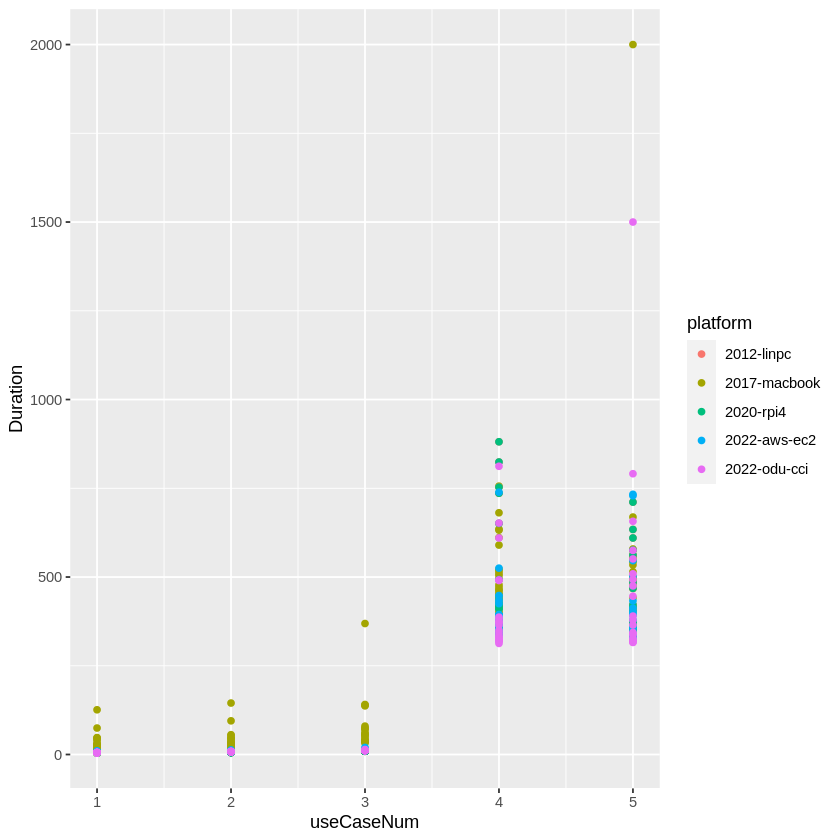

In [24]:
qplot(useCaseNum, Duration, data = spanMetricsA, colour = platform)

### Remove Macbook Data from Development Platform ###
Here we remove the data from the Macbook development platform. The qplot shows that the **Mac** added latency within the Docker environment. In non-linux based plaforms, a Docker desktop running a virtual machine is required to provided that Docker capability that is native to Linux platforms. _Consider removing Mac later after presentation of composite plots._ The Mac is considered to be the development environment and not representative of the integration and production environments.

https://dev.to/ericnograles/why-is-docker-on-macos-so-much-worse-than-linux-flh  
https://collabnix.com/how-docker-for-mac-works-under-the-hood/  

In [25]:
noMacSpan <- spanMetricsA[!spanMetricsA$env == 0,]

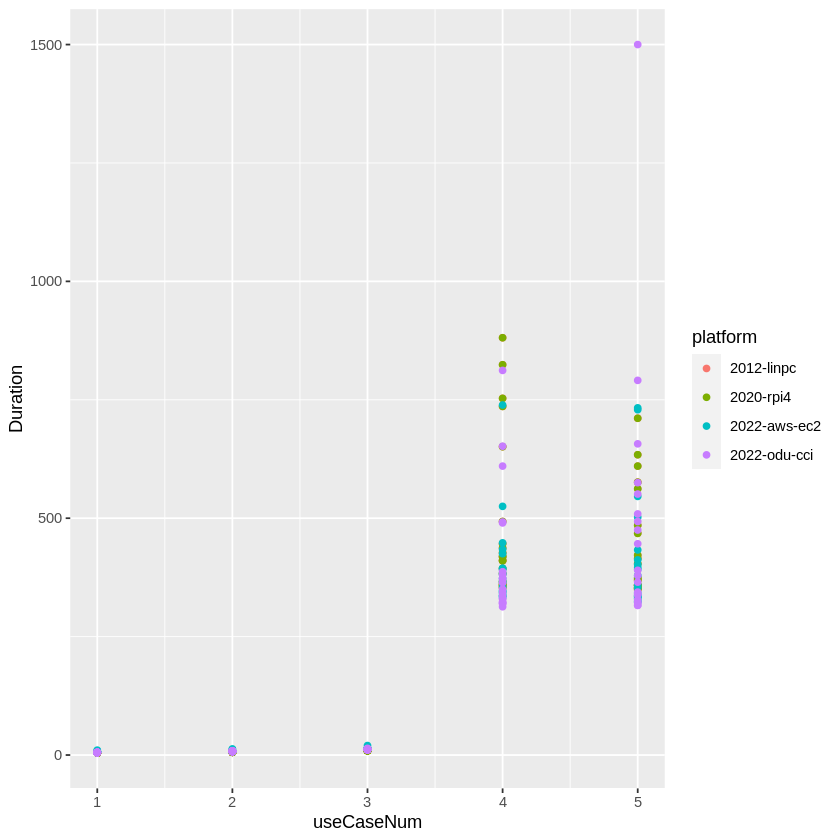

In [26]:
qplot(useCaseNum, Duration, data = noMacSpan, colour = platform)

In [27]:
# par(mfrow=c(2,1))
# hist(spanMetricsA$Duration, counts = 5)

# spanMetricsA %>%
#     ggplot(aes(Trace.name, Duration)) + 
#     stat_boxplot(notch="FALSE") + geom_point() +
#     ggtitle("Duration of Endpoint Responses from Trace")
# # notch went outside hinges. Try setting notch=FALSE.

In [28]:
# Remove outliers
aSpan <- noMacSpan
outliers <- boxplot(aSpan$Duration, plot = FALSE)$out
outliers

aSpan <- aSpan[-which(aSpan$Duration %in% outliers),]

[1] 1500

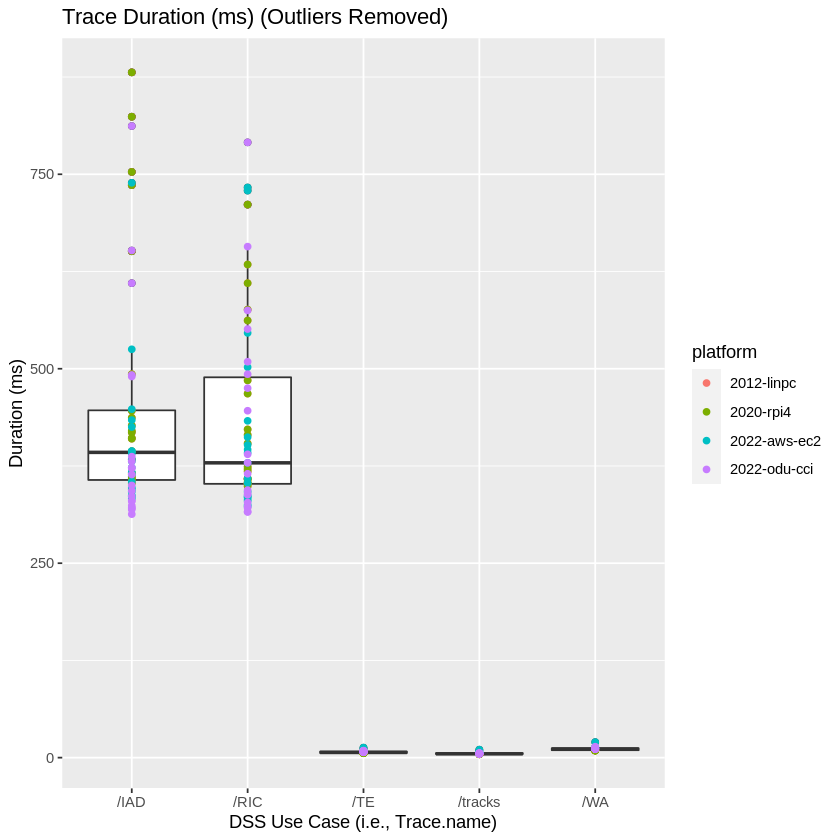

In [29]:
aSpan %>%
    ggplot(aes(Trace.name, Duration)) + 
    stat_boxplot(notch="FALSE") + geom_point(aes(colour = platform)) +
    ggtitle("Trace Duration (ms) (Outliers Removed)") +
    ylab("Duration (ms)") +
    xlab("DSS Use Case (i.e., Trace.name)")
# notch went outside hinges. Try setting notch=FALSE.

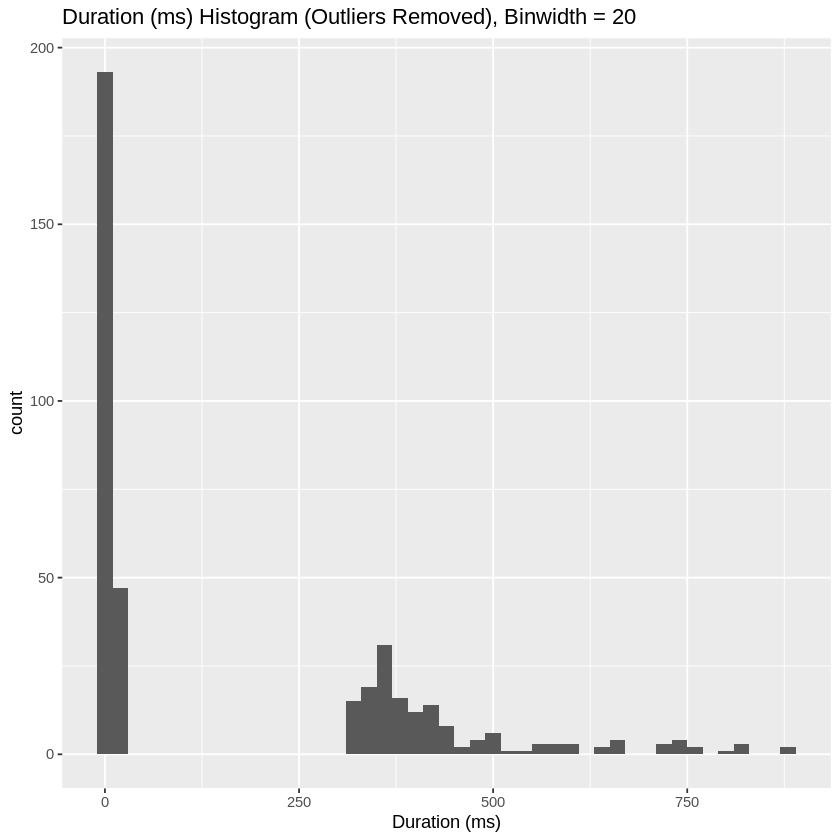

In [30]:
aSpan %>%
    ggplot(aes(Duration)) + geom_histogram(binwidth = 20) +
    ggtitle("Duration (ms) Histogram (Outliers Removed), Binwidth = 20") +
    xlab("Duration (ms)")

In [31]:
# ggpairs(spanMetricsNum, title="correlogram with ggpairs()")

#### mclust ####

Used mclust to verify the separation of internal and external models as indicated from the useCaseNum vs. Duration plot; i.e. use cases 4 and 5 use an external API.

The library mclust is a contributed R package for model-based clustering, classification, and density estimation based on finite normal mixture modelling. It provides functions for parameter estimation via the EM algorithm for normal mixture models with a variety of covariance structures, and functions for simulation from these models.


_Scrucca L., Fop M., Murphy T. B. and Raftery A. E. (2016) mclust 5: clustering, classification and density estimation using Gaussian finite mixture models The R Journal 8/1, pp. 289-317_

#### Mclust Univariate Analysis of Duration ####

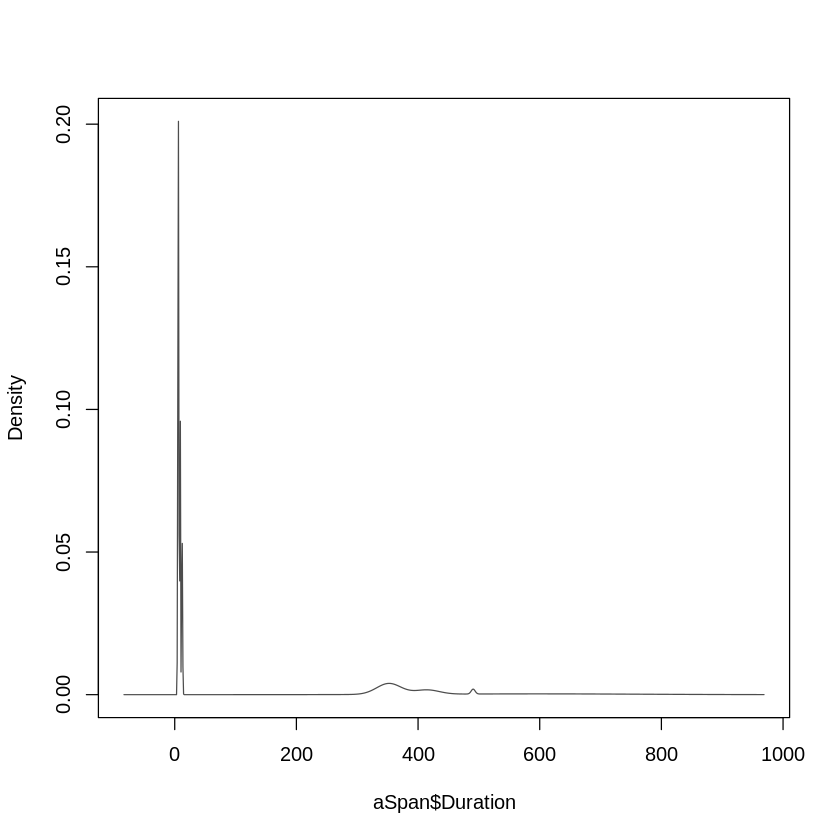

In [32]:
mod4 <- densityMclust(aSpan$Duration)

In [33]:
summary(mod4)

------------------------------------------------------- 
Density estimation via Gaussian finite mixture modeling 
------------------------------------------------------- 

Mclust V (univariate, unequal variance) model with 9 components: 

 log-likelihood   n df       BIC       ICL
      -1656.953 399 26 -3469.619 -3511.198

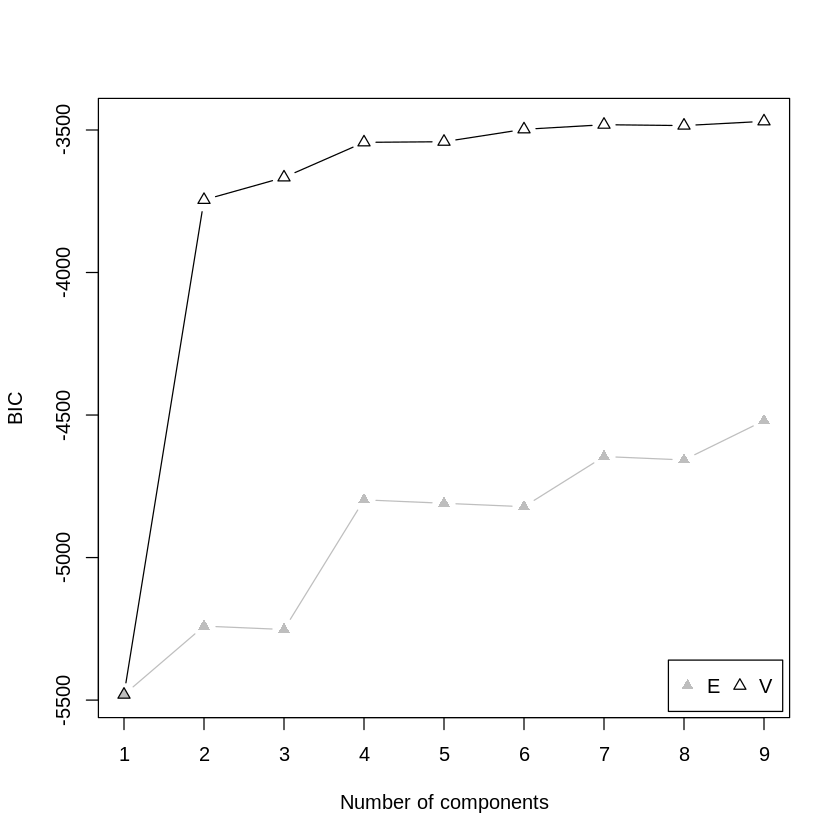

In [34]:
plot(mod4, what ="BIC")

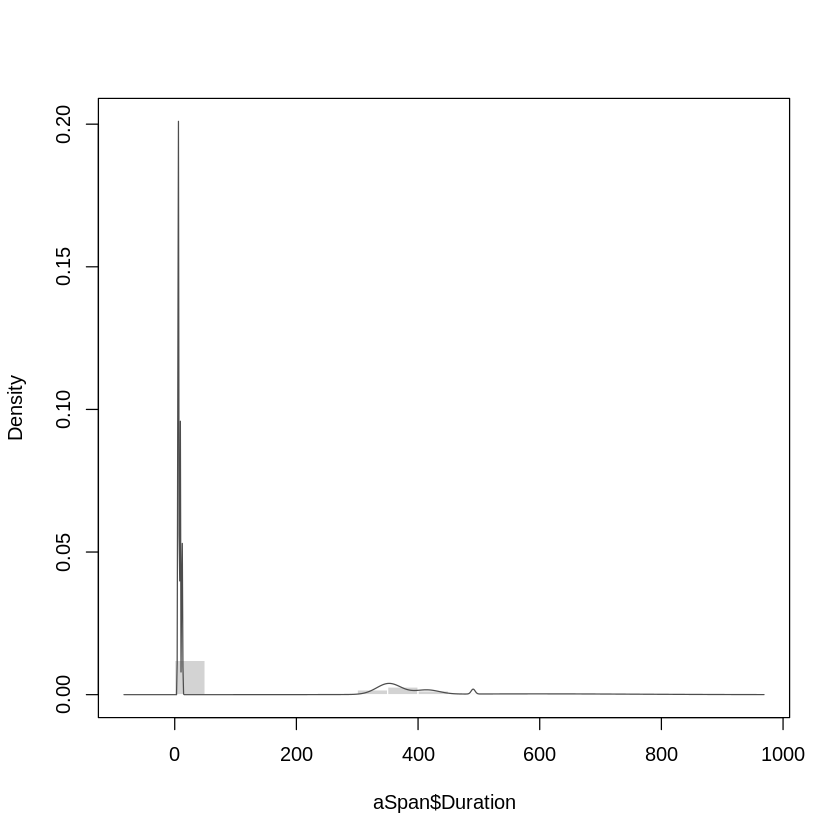

In [35]:
plot(mod4, what = "density", data = aSpan$Duration, breaks = 20)

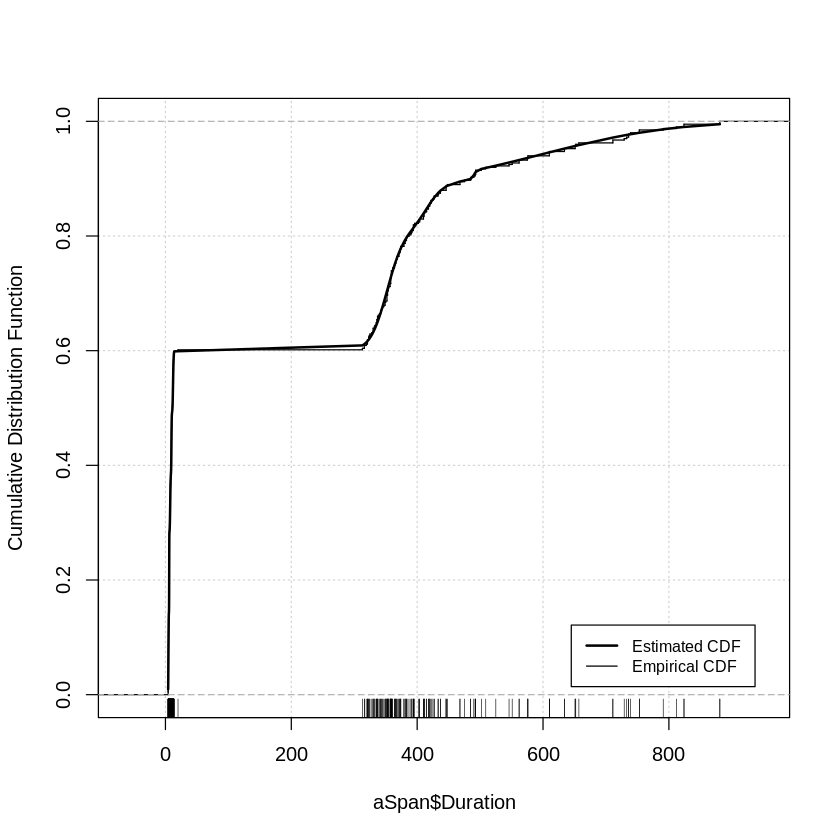

In [36]:
plot(mod4, what = "diagnostic", type = "cdf")

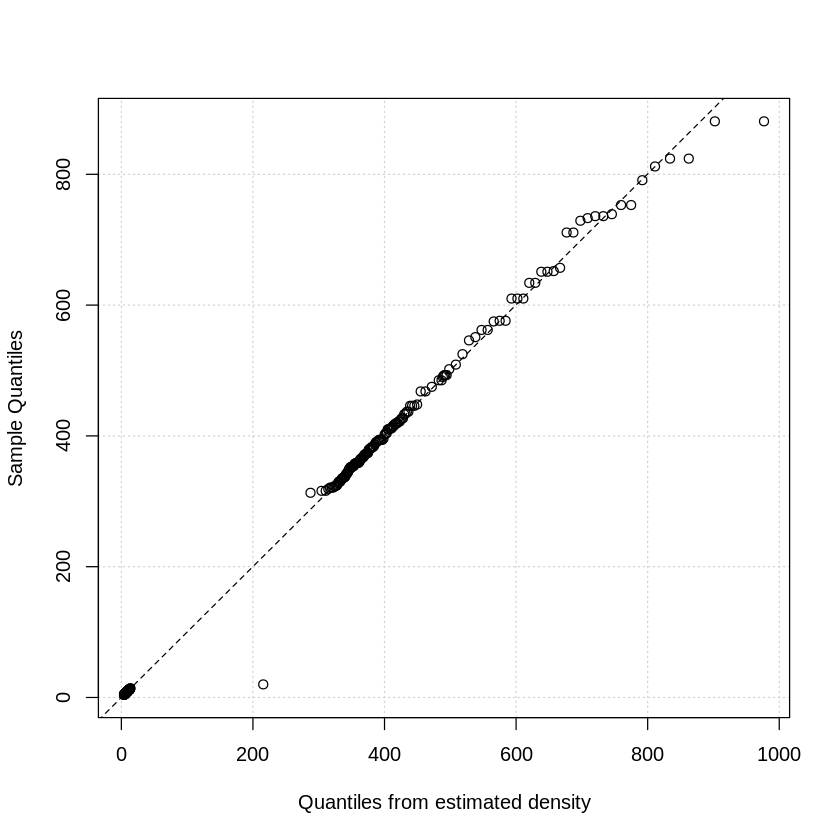

In [37]:
plot(mod4, what = "diagnostic", type = "qq")

#### Mclust Multivariate Analysis ####

,Duration,ext,env
,<dbl>,<lgl>,<dbl>
21,4.90,FALSE,1
22,4.43,FALSE,1
23,4.67,FALSE,1
24,4.68,FALSE,1
25,4.73,FALSE,1
26,4.89,FALSE,1


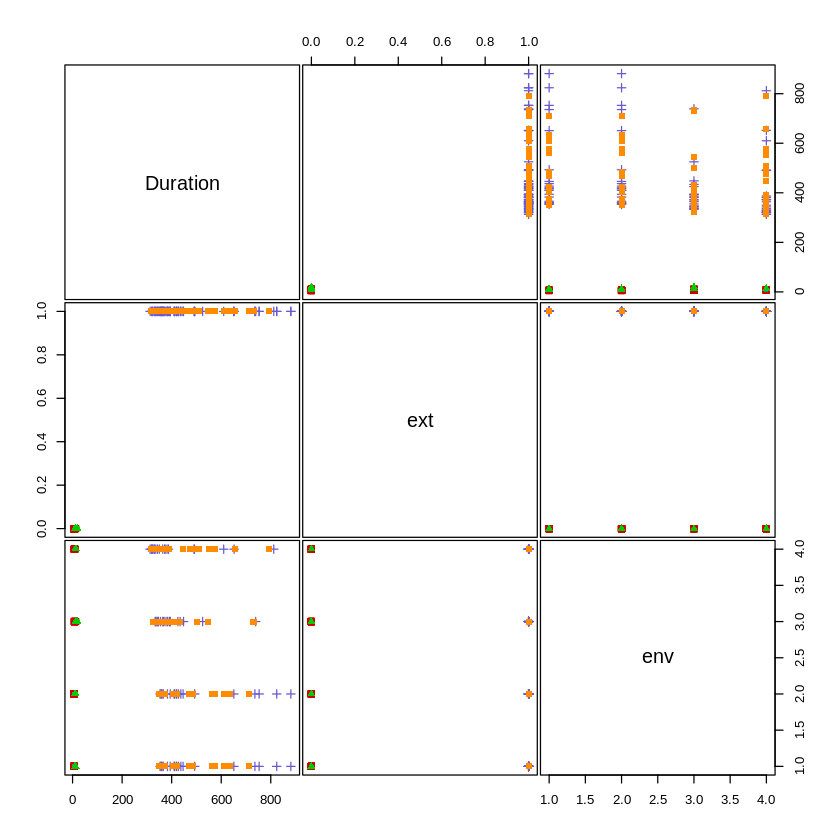

In [38]:
uc <- aSpan$useCaseNum # Trace.name is char, used uc num conversion

X <- aSpan %>%
    # dplyr::select(useCaseNum, env, ext, Duration)
    dplyr::select(Duration, ext, env)
    # dplyr::select(Duration)

head(X)
clPairs(X, uc)

In [39]:
# spanMclust <- Mclust(aSpan)
# spanMclust <- Mclust(X)
# summary(spanMclust)
# plot(spanMclust, what = c("classification"))

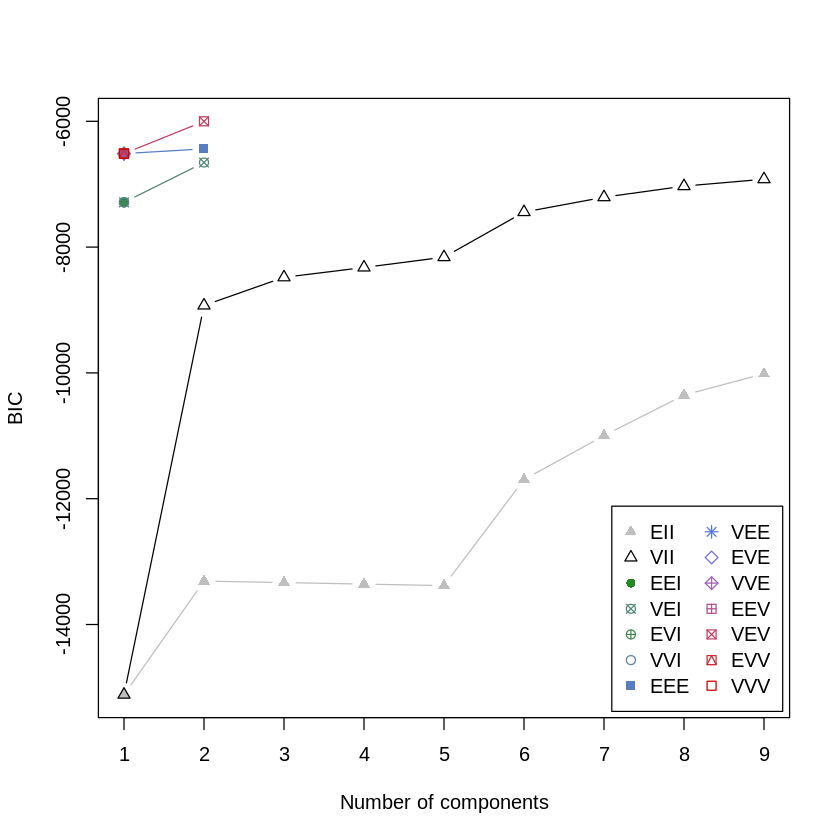

In [40]:
BIC <- mclustBIC(X)
plot(BIC)

In [41]:
summary(BIC)

Best BIC values:
             VEV,2      EEE,2      EEE,1
BIC      -6000.192 -6437.9228 -6512.9492
BIC diff     0.000  -437.7311  -512.7575

Note that 2 is included within the list of best Bayesian Information Criterion (BIC) values.

In [42]:
# mod1 <- Mclust(X, x = BIC)
# summary(mod1, parameters = TRUE)

In [43]:
# plot(mod1, what = "classification")

In [44]:
# plot(mod1, what = "uncertainty")

In [45]:
# ICL <- mclustICL(X)
# summary(ICL)
# plot(ICL)

In [46]:
# LRT <- mclustBootstrapLRT(X, modelName = "VEV")
# LRT

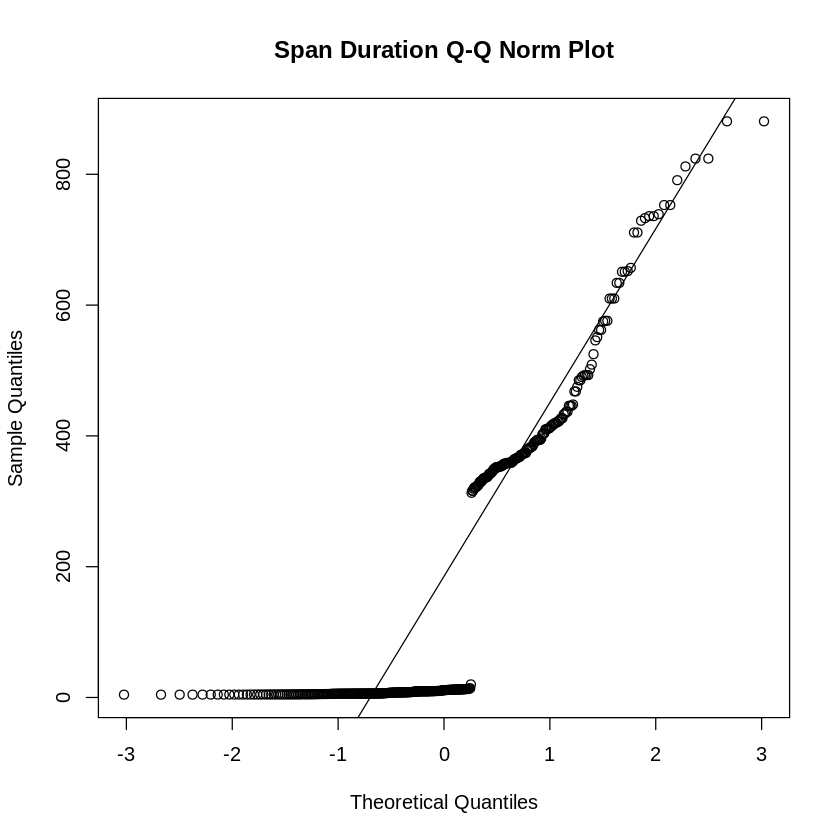

In [47]:
qqnorm(aSpan$Duration, main="Span Duration Q-Q Norm Plot")
qqline(aSpan$Duration)

In [48]:
# head(aSpan)

In [49]:
aSpan_Density <- aSpan %>%
    # dplyr::select(useCaseNum, env, ext, Duration)
    dplyr::select(ext, Duration)
    # dplyr::select(Duration)

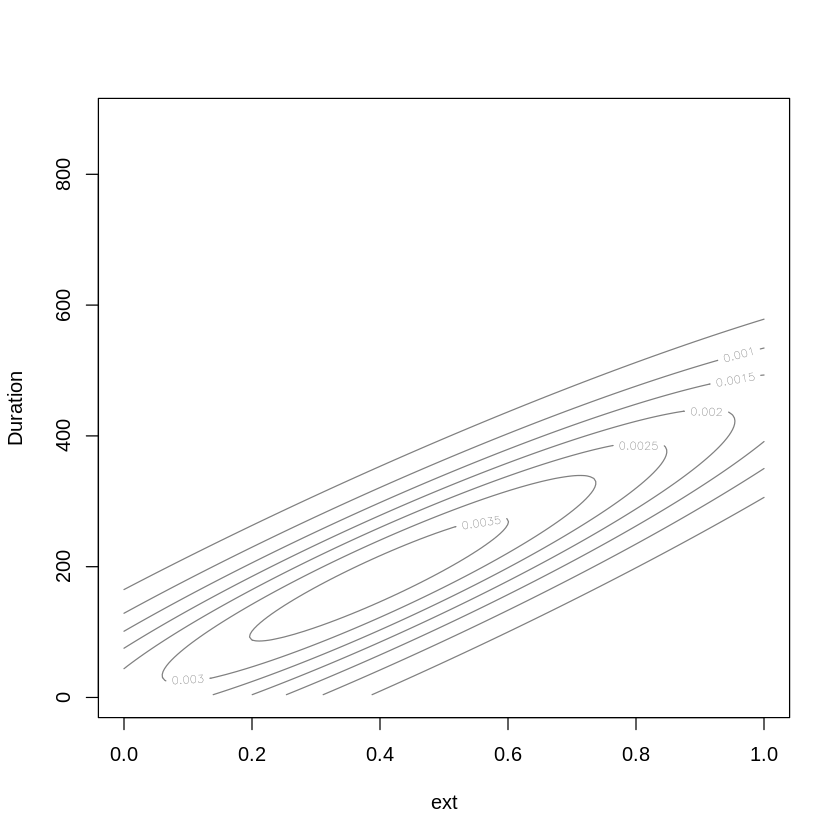

In [50]:
mod5 <- densityMclust(aSpan_Density)

In [51]:
# aSpan <- spanMetricsNum

In [52]:
# sqrt_aSpan <- aSpan
# sqrt_aSpan$Duration=sqrt(sqrt_aSpan$Duration)
# log_aSpan <- aSpan
# # log_aSpan$Duration=log(log_aSpan$Duration + 1)
# log_aSpan$Duration=log(log_aSpan$Duration)
# cube_aSpan <- aSpan
# cube_aSpan$Duration=cube_aSpan$Duration^(1/3)

# par(mfrow=c(2,2))
# hist(aSpan$Duration, counts = 5)
# hist(sqrt_aSpan$Duration)
# hist(log_aSpan$Duration)
# hist(cube_aSpan$Duration)

In [53]:
# par(mfrow=c(2,2))
# qqnorm(aSpan$Duration, main="Span Duration Q-Q Norm Plot")
# qqline(aSpan$Duration)

# qqnorm(sqrt_aSpan$Duration, main="Sqrt Span Duration Q-Q Norm Plot")
# qqline(sqrt_aSpan$Duration)

# qqnorm(log_aSpan$Duration, main="Log Span Duration Q-Q Norm Plot")
# qqline(log_aSpan$Duration)

# qqnorm(cube_aSpan$Duration, main="Cube Span Duration Q-Q Norm Plot")
# qqline(cube_aSpan$Duration)

In [54]:
# # y = response (duration/latency)
# # x = use case number

# # #find optimal lambda for Box-Cox transformation 
# # bc <- boxcox(y ~ x)
# # (lambda <- bc$x[which.max(bc$y)])

# # #fit new linear regression model using the Box-Cox transformation
# # new_model <- lm(((y^lambda-1)/lambda) ~ x)

# # bcData = aSpan
# # y <- bcData$Duration
# # x <- bcData$useCaseNum

# # bc <- boxcox(y ~ x)
# # (lambda <- bc$x[which.max(bc$y)])
# # new_model <- lm(((y^lambda-1)/lambda) ~ x)

# # https://r-coder.com/box-cox-transformation-r/

# # boxcox(lm(aSpan$Duration ~ 1))

# x <- aSpan$Duration

# b <- boxcox(lm(x ~ 1))

# # Exact lambda
# lambda <- b$x[which.max(b$y)]

# # Transformation
# new_x_bc <- (x ^ lambda - 1) / lambda

In [55]:
# par(mfrow=c(2,2))
# hist(aSpan$Duration)
# hist(new_x_bc)

# qqnorm(aSpan$Duration)
# qqline(aSpan$Duration)

# qqnorm(new_x_bc)
# qqline(new_x_bc)

In [56]:
# shapiro.test(new_x_bc)

## Separating Internal from External Data ##

### Internal Data ###

In [57]:
# Separate Internal Data
# Could use ext == FALSE

tracksSpanData = subset(aSpan, useCaseNum == 1)
TE_SpanData = subset(aSpan, useCaseNum == 2)
WA_SpanData = subset(aSpan, useCaseNum == 3)

internalSpanData <- rbind(tracksSpanData, TE_SpanData, WA_SpanData)
dssSpanData <- rbind(TE_SpanData, WA_SpanData)

# tracksSpanData
# TE_SpanData
# WA_SpanData
# internalSpanData
# dssSpanData

In [58]:
# Remove Outliers
# outliers <- boxplot(internalSpanData$Duration, plot = FALSE)$out
# outliers
# iSpan <- iSpan[-which(iSpan$Duration %in% outliers),]

outliers <- which(internalSpanData$Duration > 50) #outlier rows
outliers
# iSpan <- internalSpanData[!outliers,]
iSpan <- internalSpanData[!internalSpanData$Duration > 50,]
    # Remove if duration is greater than a value

# iSpan

integer(0)

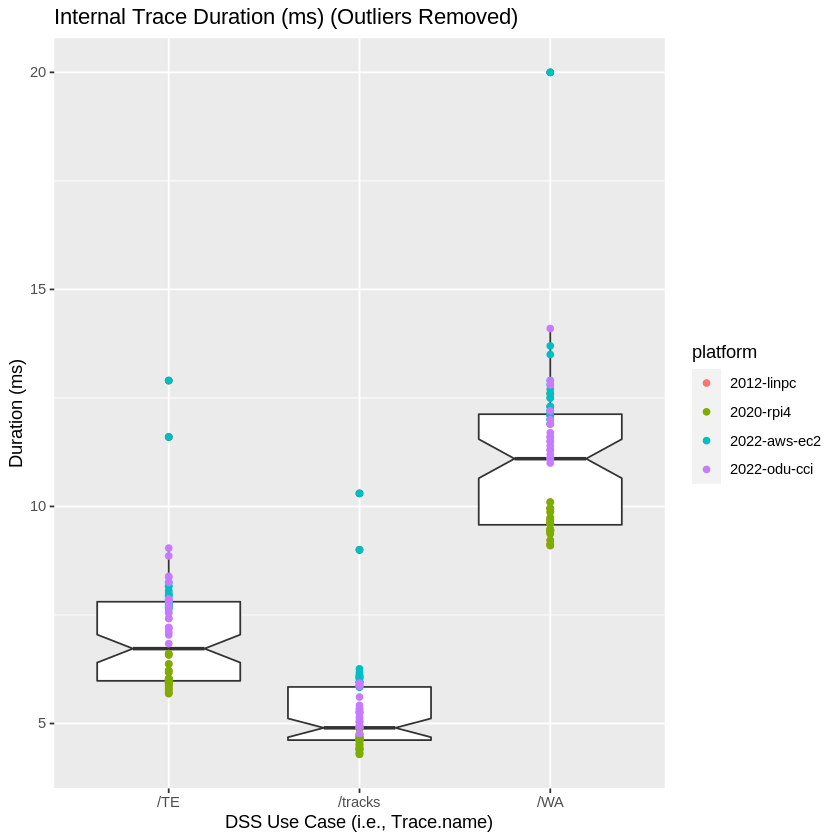

In [59]:
iSpan %>%
    ggplot(aes(Trace.name, Duration)) + 
    stat_boxplot(notch="TRUE") + geom_point(aes(colour = platform)) +
    ggtitle("Internal Trace Duration (ms) (Outliers Removed)") +
    ylab("Duration (ms)") +
    xlab("DSS Use Case (i.e., Trace.name)")

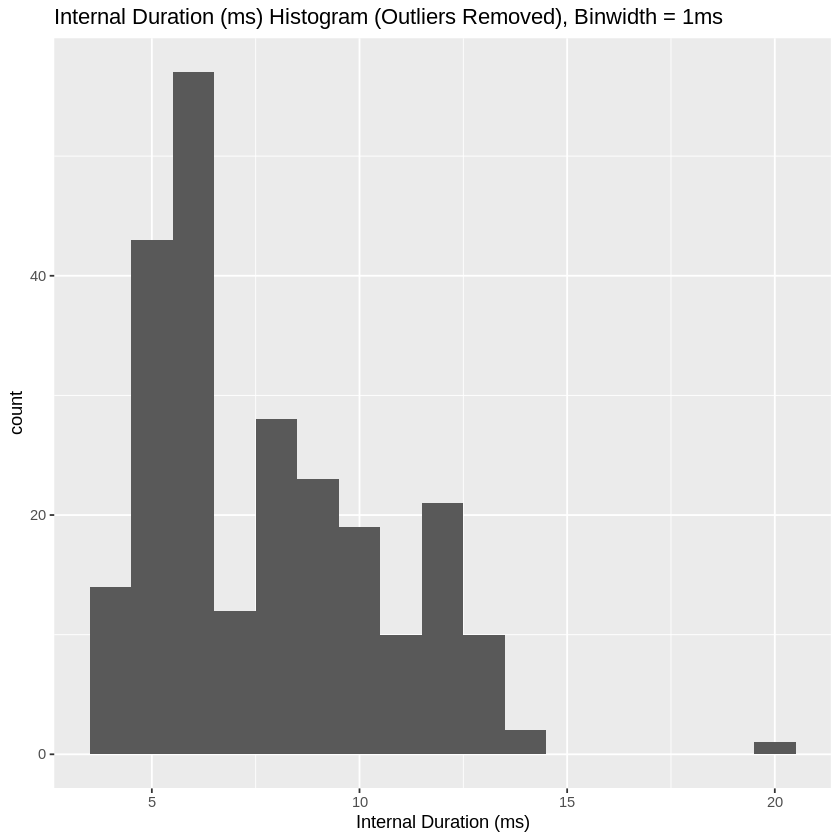

In [60]:
iSpan %>%
    ggplot(aes(Duration)) + geom_histogram(binwidth = 1) +
    ggtitle("Internal Duration (ms) Histogram (Outliers Removed), Binwidth = 1ms") +
    xlab("Internal Duration (ms)")

Note that the plot is not normalized and will need a transformation to enable application of statistics.

### External Data ###

In [61]:
RIC_SpanData = subset(aSpan, useCaseNum == 5)
IAD_SpanData = subset(aSpan, useCaseNum == 4)

# RIC_SpanData = subset(spanMetricsA, Trace.name == "/RIC")
# IAD_SpanData = subset(spanMetricsA, Trace.name == "/IAD")

externalSpanData <- rbind(RIC_SpanData, IAD_SpanData)

In [62]:
# Remove outliers
# outliers <- boxplot(externalSpanData$Duration, plot = FALSE)$out
# outliers

eSpan <- externalSpanData
# eSpan <- eSpan[-which(eSpan$Duration %in% outliers),]

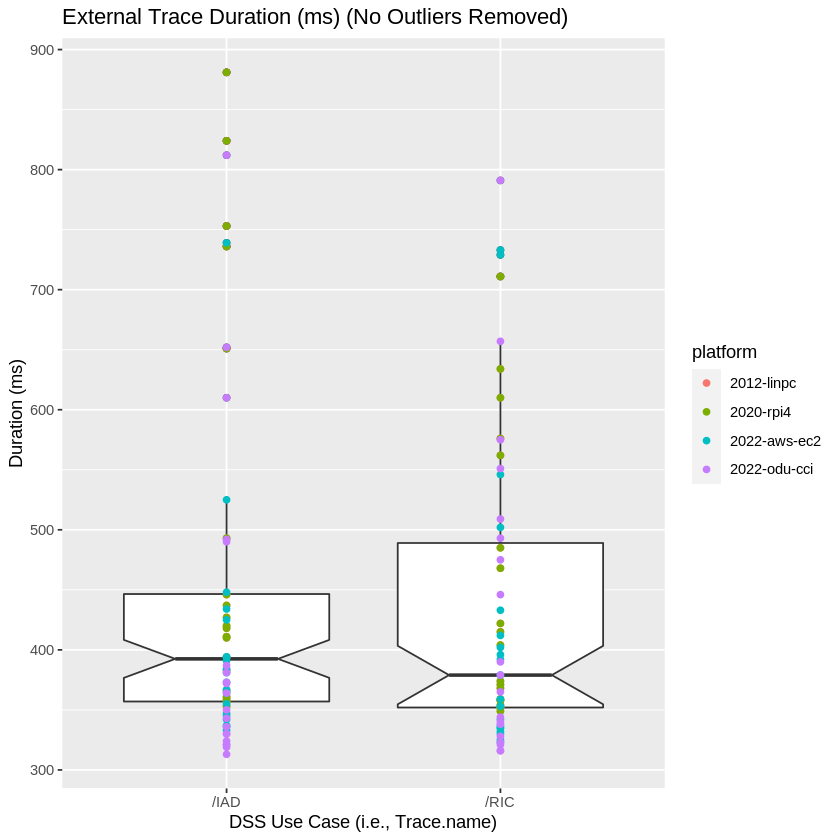

In [63]:
eSpan %>%
    ggplot(aes(Trace.name, Duration)) + 
    stat_boxplot(notch="TRUE") + geom_point(aes(colour = platform)) +
    ggtitle("External Trace Duration (ms) (No Outliers Removed)") +
    ylab("Duration (ms)") +
    xlab("DSS Use Case (i.e., Trace.name)")

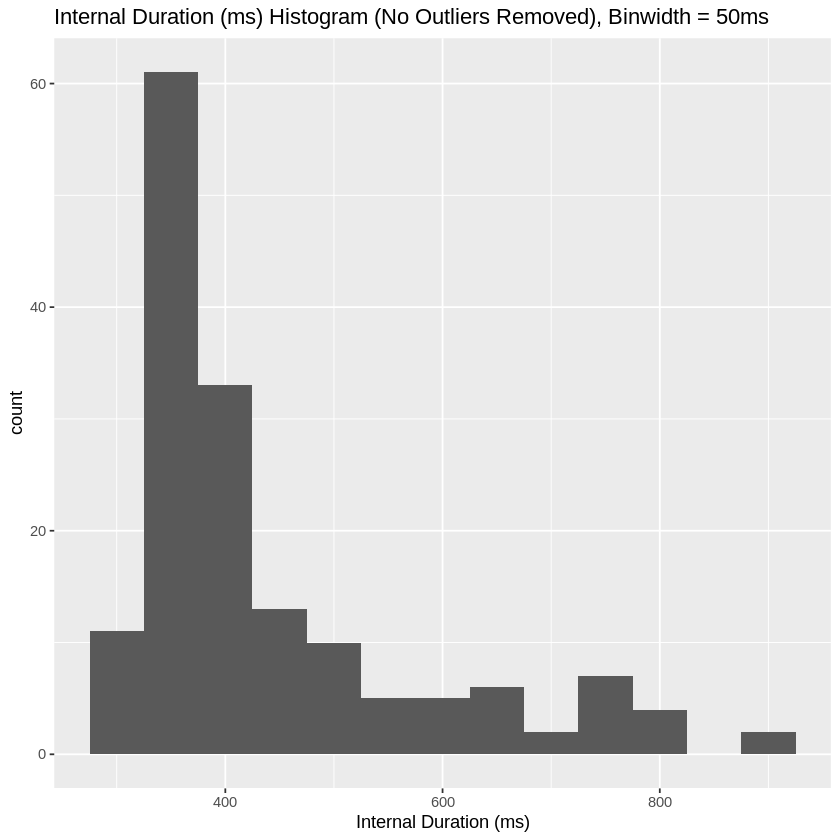

In [64]:
eSpan %>%
    ggplot(aes(Duration)) + geom_histogram(binwidth = 50) +
    ggtitle("Internal Duration (ms) Histogram (No Outliers Removed), Binwidth = 50ms") +
    xlab("Internal Duration (ms)")

Note that the plot is not normalized and will need a transformation to enable application of statistics.

#### Data Transformations (Internal Data) ####

##### Sqrt-Log-Cube Transformations #####

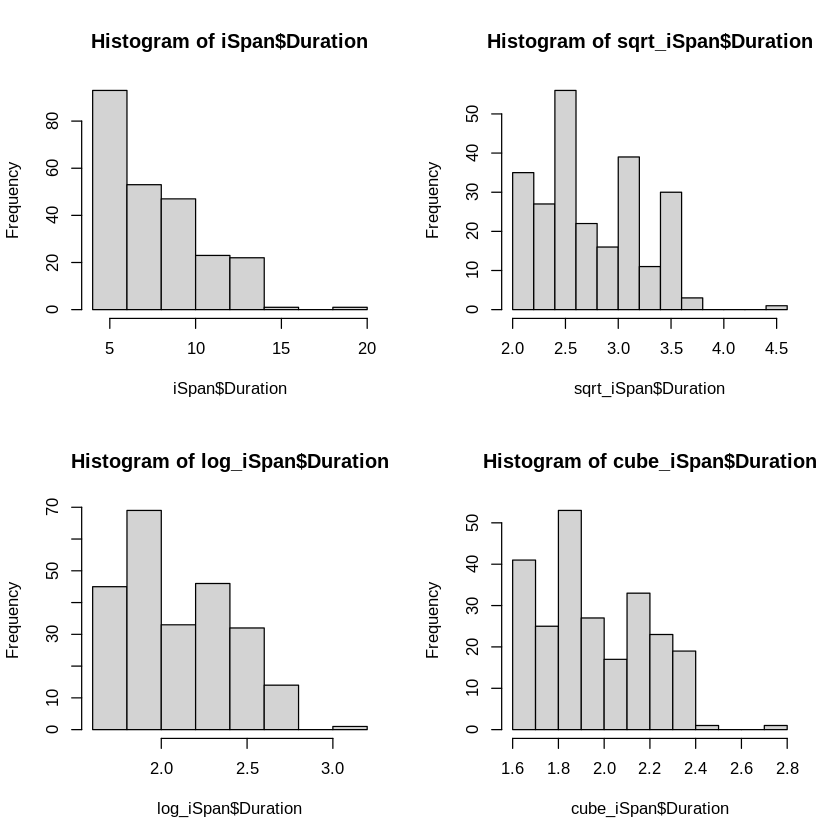

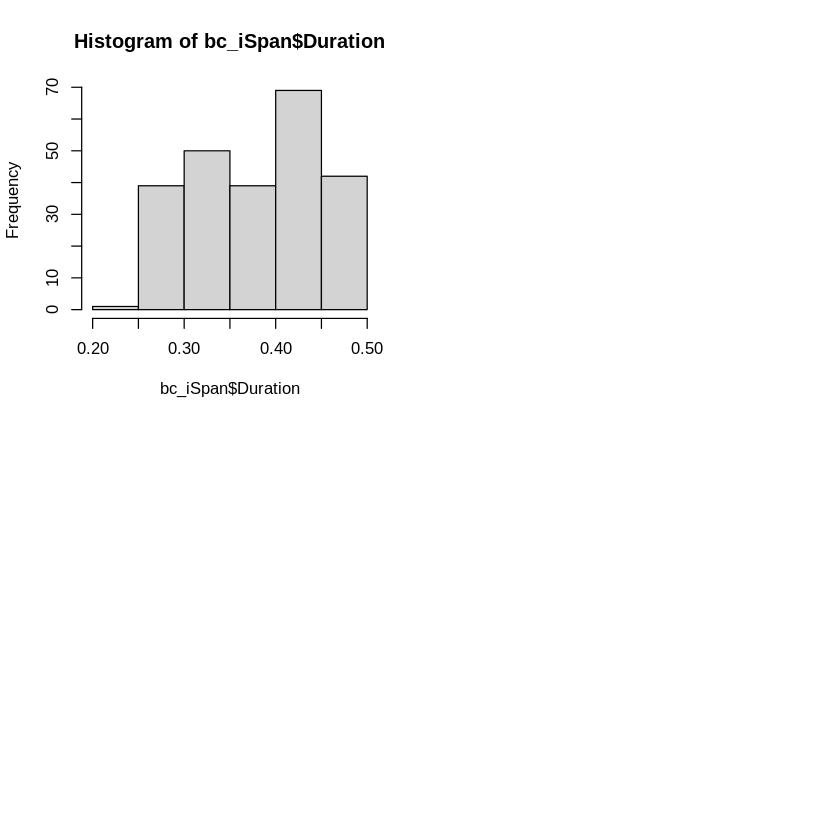

In [77]:
sqrt_iSpan <- iSpan
sqrt_iSpan$Duration=sqrt(sqrt_iSpan$Duration)
log_iSpan <- iSpan
log_iSpan$Duration=log(log_iSpan$Duration + 1)
cube_iSpan <- iSpan
cube_iSpan$Duration=cube_iSpan$Duration^(1/3)
# bc_iSpan <- iSpan
# bc_iSpan$Duration=1/sqrt(bc_iSpan$Duration)

par(mfrow=c(2,2))
hist(iSpan$Duration, counts = 10)
hist(sqrt_iSpan$Duration)
hist(log_iSpan$Duration)
hist(cube_iSpan$Duration)
# hist(bc_iSpan$Duration)

#### Box-Cox Transformation ####

Box and Cox (1964) developed a family of transformations designed to reduce nonnormality of the errors in a linear model. Applying this transform often reduces non-linearity as well, and heteroscedascity.

The idea is to transform the response variable $Y$ to a replacement response variable $Y_i^{(\lambda)}$, leaving the right-hand side of the regression model unchanged, so that the regression residuals become normally-distributed. Note that the regression coefficients will also change, because the response variable has changed; therefore, the regression coefficients must be interpreted with respect to the transformed variable. Also, any predictions made with the model have to be back-transformed, to be interpreted in the original units.

The standard (simple) Box-Cox transform is:

$$
    Y_i^{(\lambda)}=
\begin{cases}
{\frac {Y_i^\lambda - 1} \lambda},  & {(\lambda \neq 0)} \\
log(Y_i), & {(\lambda = 0)}
\end{cases}
$$

_Box, G. E. P., & Cox, D. R. (1964). An Analysis of Transformations. Journal of the Royal Statistical Society, Series B (Metholodogical), 26(2), 211-252._

http://www.css.cornell.edu/faculty/dgr2/_static/files/R_html/Transformations.html

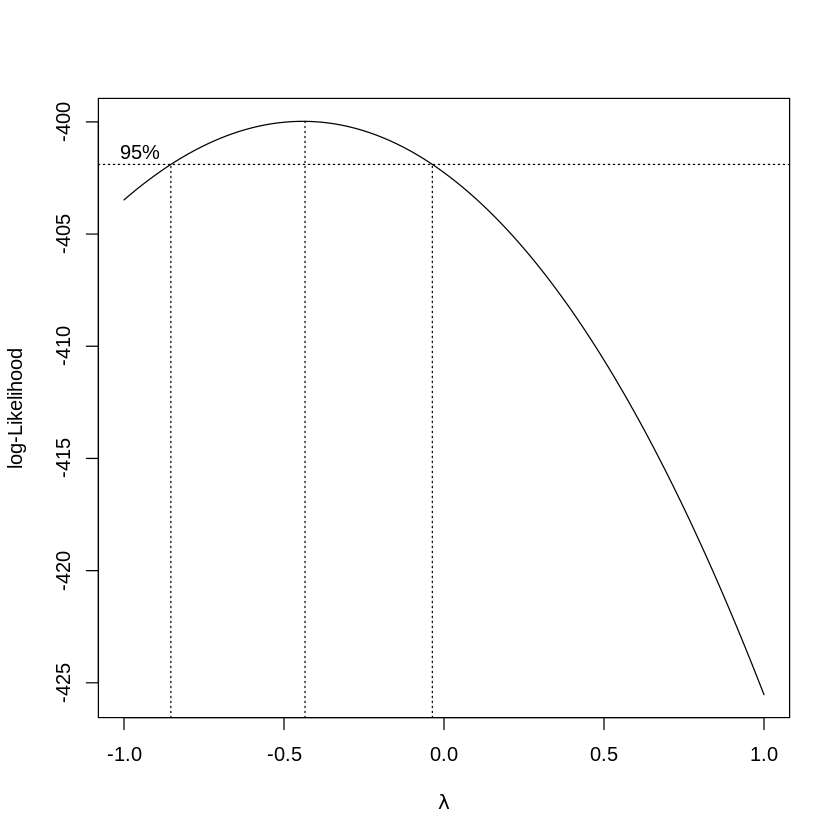

In [66]:
bcData = iSpan
x <- bcData$Duration
bc = boxcox(lm(x ~ 1), seq(-1,1,.1))
# bc = boxcox(lm(x ~ bcData$useCaseNum))
lambda <- bc$x[which.max(bc$y)]
new_x_exact <- (x ^ lambda - 1) / lambda

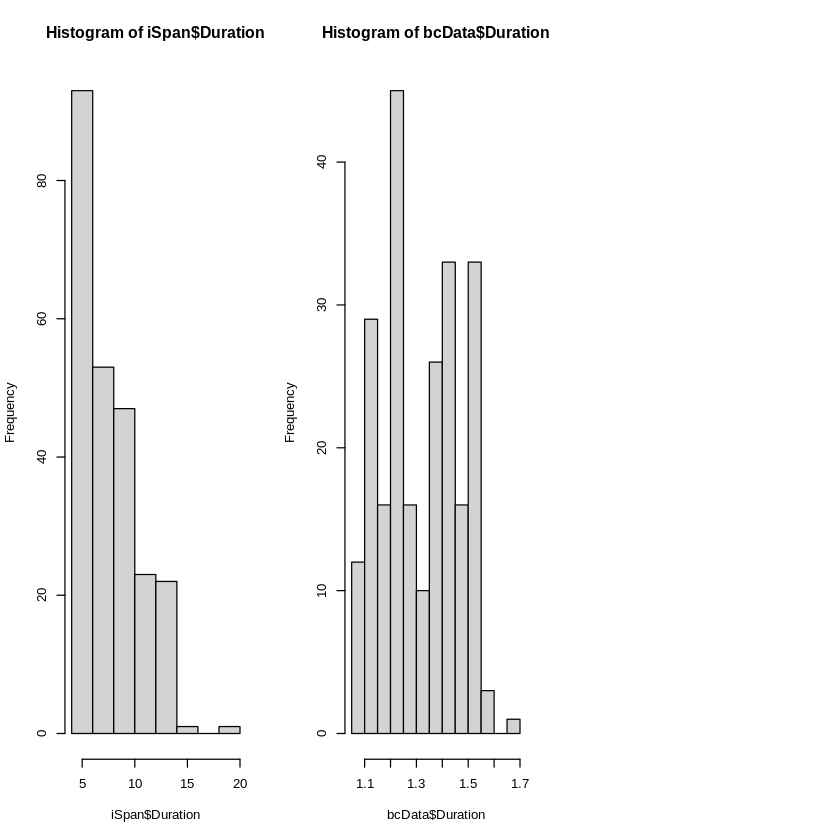

In [67]:
bcData$Duration = new_x_exact
par(mfrow=c(1,3))
hist(iSpan$Duration)
hist(bcData$Duration)

### Normality Testing of the Trasformation ###

#### Shapiro-Wilk ####

The null-hypothesis of this test is that the population is normally distributed. Thus, if the p value is less than the chosen alpha level, then the null hypothesis is rejected and there is evidence that the data tested are not normally distributed. On the other hand, if the p value is greater than the chosen alpha level, then the null hypothesis (that the data came from a normally distributed population) can not be rejected (e.g., for an alpha level of .05, a data set with a p value of less than .05 rejects the null hypothesis that the data are from a normally distributed population).

https://en.wikipedia.org/wiki/Shapiro–Wilk_test

In [68]:
shapiro.test(bcData$Duration)


	Shapiro-Wilk normality test

data:  bcData$Duration
W = 0.9466, p-value = 1.06e-07


With p-value of _____ < 0.05 we reject the null hypothesis that the data are from a normally distributed population. But we'll also do a Q-Q Norm plot to visually see the results.

_"if the p value is greater than the chosen alpha level, then the null hypothesis (that the data came from a normally distributed population) can not be rejected"_

##### Shapiro-Wilk Testing Sqrt-Log-Cube #####

In [78]:
shapiro.test(sqrt_iSpan$Duration)
shapiro.test(log_iSpan$Duration)
shapiro.test(cube_iSpan$Duration)
# shapiro.test(bc_iSpan$Duration)


	Shapiro-Wilk normality test

data:  sqrt_iSpan$Duration
W = 0.93106, p-value = 3.692e-09



	Shapiro-Wilk normality test

data:  log_iSpan$Duration
W = 0.94087, p-value = 2.892e-08



	Shapiro-Wilk normality test

data:  cube_iSpan$Duration
W = 0.93634, p-value = 1.092e-08



	Shapiro-Wilk normality test

data:  bc_iSpan$Duration
W = 0.94652, p-value = 1.039e-07


The **cube transformation** seems to provide the best q-q plot fit. With a p-value of _____ > 0.05 we fail to reject the null hypothesis and assume we now have a normal distribution. 

_"if the p value is greater than the chosen alpha level, then the null hypothesis (that the data came from a normally distributed population) can not be rejected"_

#### Hypothesis Testing ####

We will use a Student's t-Test to test the hypothesis on **normal** internal span data. Our mean is 500 ms (e.g. $\mu = 0.5$ seconds) and our null hypthesis is less than 500 ms.

In [70]:
mu = 0.5
x = cube_iSpan$Duration
cube_mu = mu^(1/3)
t.test(x=x, mu=cube_mu, alternative = 'greater')


	One Sample t-test

data:  x
t = 78.692, df = 239, p-value < 2.2e-16
alternative hypothesis: true mean is greater than 0.7937005
95 percent confidence interval:
 1.927618      Inf
sample estimates:
mean of x 
 1.951922 


In [71]:
mu = 0.5
x = iSpan$Duration
t.test(x=x, mu=mu, alternative = 'greater')


	One Sample t-test

data:  x
t = 40.422, df = 239, p-value < 2.2e-16
alternative hypothesis: true mean is greater than 0.5
95 percent confidence interval:
 7.448918      Inf
sample estimates:
mean of x 
 7.744875 


With a original and transformation with a p-value of ___ > 0.05 we fail to reject the null hypothesis, i.e. we assume that latency will be less than 500 ms.

_"If the p value is greater than the chosen alpha level, then the null hypothesis (that latency is < 500 ms) can not be rejected"_

### External Data ###

#### Q-Q Norm Plot of "Clean" External Span Data ####

We'll look a the Q-Q Norm Plot and Shapiro-Wilk Test

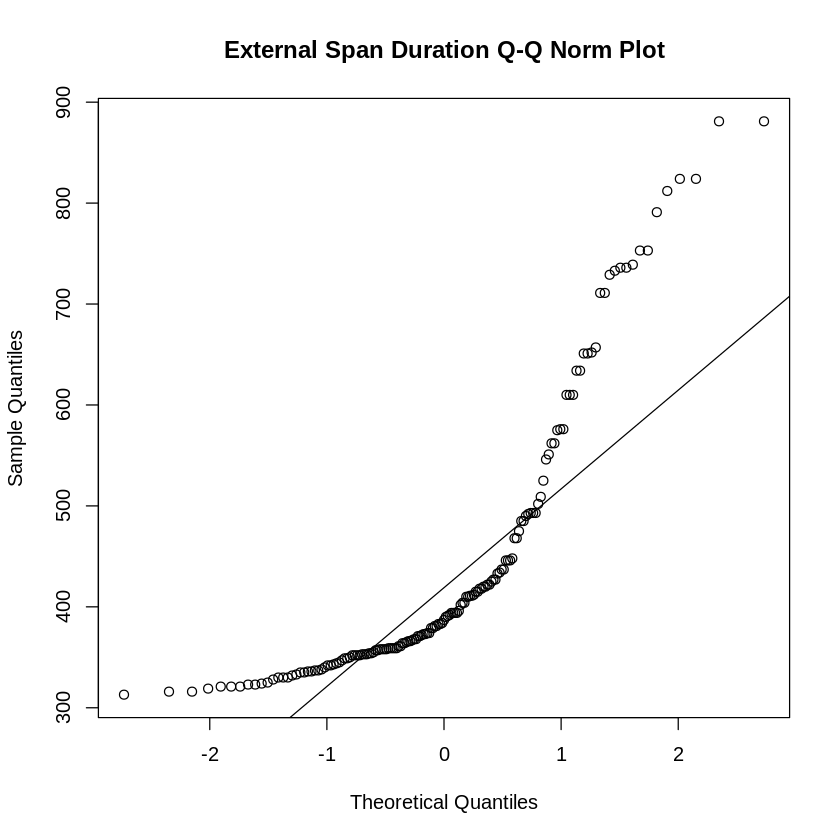

In [72]:
qqnorm(eSpan$Duration, main="External Span Duration Q-Q Norm Plot")
qqline(eSpan$Duration)

##### Sqrt-Log-Cube Transformations #####

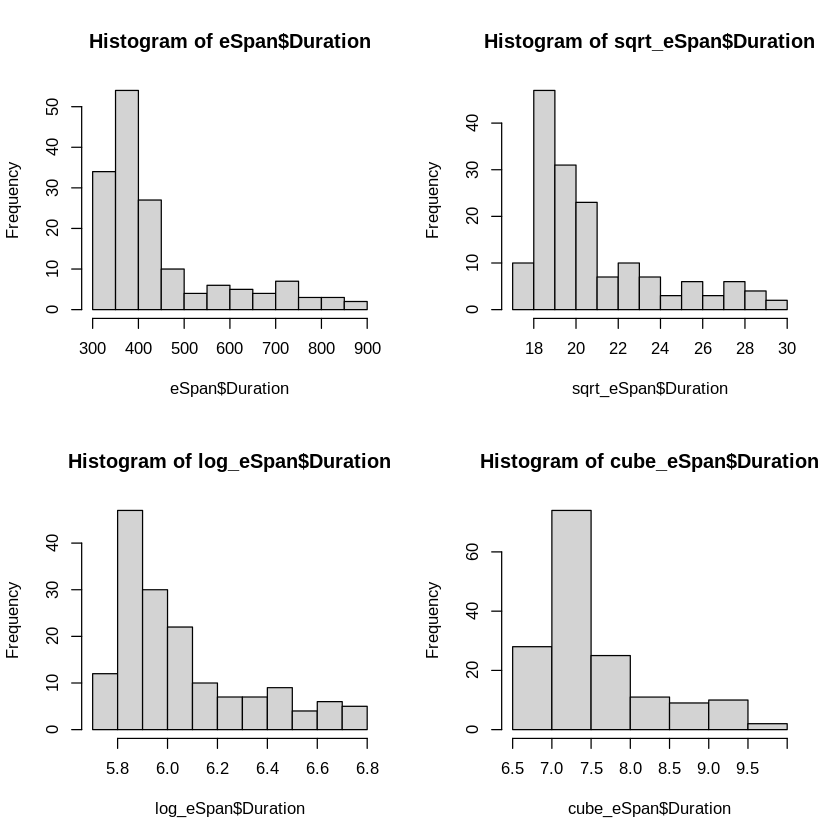

In [73]:
sqrt_eSpan <- eSpan
sqrt_eSpan$Duration=sqrt(sqrt_eSpan$Duration)
log_eSpan <- eSpan
log_eSpan$Duration=log(log_eSpan$Duration + 1)
cube_eSpan <- eSpan
cube_eSpan$Duration=cube_eSpan$Duration^(1/3)

par(mfrow=c(2,2))
hist(eSpan$Duration, counts = 50)
hist(sqrt_eSpan$Duration)
hist(log_eSpan$Duration)
hist(cube_eSpan$Duration)

#### Shapiro-Wilk Normality Test ####

In [74]:
shapiro.test(sqrt_eSpan$Duration)
shapiro.test(log_eSpan$Duration)
shapiro.test(cube_eSpan$Duration)
shapiro.test(eSpan$Duration)


	Shapiro-Wilk normality test

data:  sqrt_eSpan$Duration
W = 0.81964, p-value = 9.941e-13



	Shapiro-Wilk normality test

data:  log_eSpan$Duration
W = 0.85298, p-value = 2.506e-11



	Shapiro-Wilk normality test

data:  cube_eSpan$Duration
W = 0.83121, p-value = 2.898e-12



	Shapiro-Wilk normality test

data:  eSpan$Duration
W = 0.78293, p-value = 4.439e-14


With a p-value of _____ > 0.05 we fail to reject the null hypothesis, i.e. we assume that we have a normal distribution.

_"if the p value is greater than the chosen alpha level, then the null hypothesis (that the data came from a normally distributed population) can not be rejected"_

#### Hypothesis Testing ####

We will use a Student's t-Test to test the hypothesis on external span data. Our mean is 500 ms (e.g. $\mu = 0.5$ seconds) and our null hypthesis is less than 500 ms.

In [75]:
mu = 0.5

In [76]:
x = eSpan$Duration
t.test(x=x, mu=mu, alternative = 'greater')


	One Sample t-test

data:  x
t = 41.115, df = 158, p-value < 2.2e-16
alternative hypothesis: true mean is greater than 0.5
95 percent confidence interval:
 424.4261      Inf
sample estimates:
mean of x 
 442.2013 


With a p-value of _____ > 0.05 we fail to reject the null hypothesis, i.e. we assume that 500 ms can be maintained for external service requests.

_"If the p value is greater than the chosen alpha level, then the null hypothesis (that latency is < 500 ms) can not be rejected"_

## Observations ##

### General Discussion of Normality ###
It was required to separate external data from internal to establish normality of the data samples. The internal data set required transformation to establish normality, while the external data did not require a transformation. 

### Hypothesis Results ###

Hypothesis testing using the Student's t-Test indicates that latency constraints of 500 ms can be maintained internally and external. However, serveral external samples were greater than 500 ms. This is most likely due to the non-deterministic nature of internet (e.g. http) requests. Within the internal environment, data is directly routed between microservices within the Docker environment within a private network. The data shows that a container based microservice architecture can meet the requirement; however, care must be taken to manage processing per container that may increase container response times.

### DSS Prototype Environment ###

The non deterministic nature of the Docker environment on the MacBook laptop significantly affected the ability to assess deterministic behavior. Boxplots of data inclusive of what was sampled from the MacBook clearly depicted this issue. Linux platforms truly run a container as intended; however, non-linux platform require the use of a Linux based Virtual Machine on top of the host OS to implement containers. While the MacBook met the needs for rapid software development, the use of a separate integration and test environment was clearly validated through the collected data.